In [1]:
import pandas as pd

filenames = [
    "Cooling energy.csv",
    "Heating energy.csv",
    "HVAC Power.csv",
    "Indoor ambient temperature.csv",
    "Water flow in radiators.csv"
]

for file in filenames:
    print(f"\n📄 {file}")
    try:
        df = pd.read_csv(file, parse_dates=["datetime"])
        print(df.head())
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")



📄 Cooling energy.csv
                 datetime  Value
0 2016-06-27 19:00:20.063  153.0
1 2016-06-28 11:36:57.680  154.0
2 2016-07-05 14:04:45.863  155.0
3 2016-07-05 16:20:19.507  156.0
4 2016-07-05 16:20:19.510  156.0

📄 Heating energy.csv
                 datetime  Value
0 2016-06-27 19:00:03.763  820.0
1 2016-07-04 09:38:56.477  821.0
2 2016-10-14 07:48:54.927  822.0
3 2016-10-17 06:48:49.820  823.0
4 2016-10-17 08:51:50.707  824.0

📄 HVAC Power.csv
                 datetime  Value
0 2016-06-27 18:45:12.680 -161.0
1 2016-06-27 18:50:12.680 -651.0
2 2016-06-27 18:55:12.687 -210.0
3 2016-06-27 19:00:13.687 -210.0
4 2016-06-27 19:05:12.687    0.0

📄 Indoor ambient temperature.csv
                 datetime      Value
0 2016-05-24 15:06:28.187  24.253557
1 2016-05-24 16:05:29.203  24.253557
2 2016-05-24 16:06:28.190  24.190825
3 2016-05-24 16:43:29.190  24.190825
4 2016-05-24 16:44:28.200  24.125097

📄 Water flow in radiators.csv
                 datetime  Value
0 2016-06-27 18:44:04.68


Fitting RC model...

Final RC model parameters:
a = 0.999000
c = 0.000000
d = 0.000011

6. Evaluating model performance...
Model evaluation results:
MSE: 0.023052
R²: 0.995276

7. Physical interpretation of the model:
Building thermal time constant: 999.50 hours
Building thermal capacity factor: 0.000000
HVAC power influence factor: 0.000011

6. Evaluating model performance...

Residuals Statistics:
Mean residual: -0.023106
Standard deviation: 0.150062
Max residual: 1.318959
Min residual: -1.544430


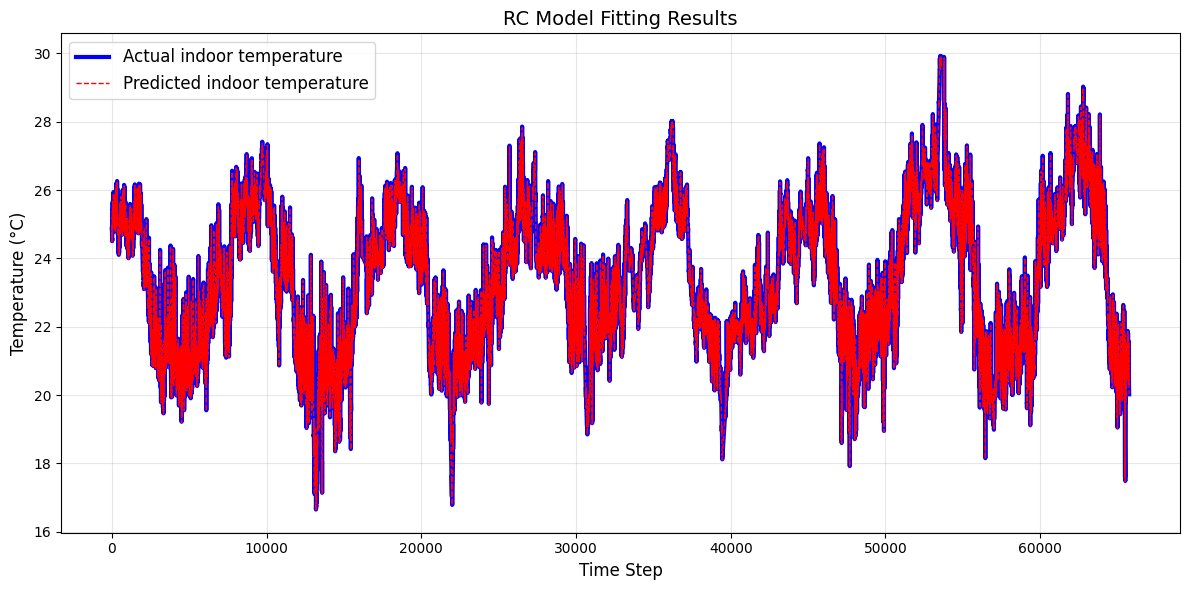

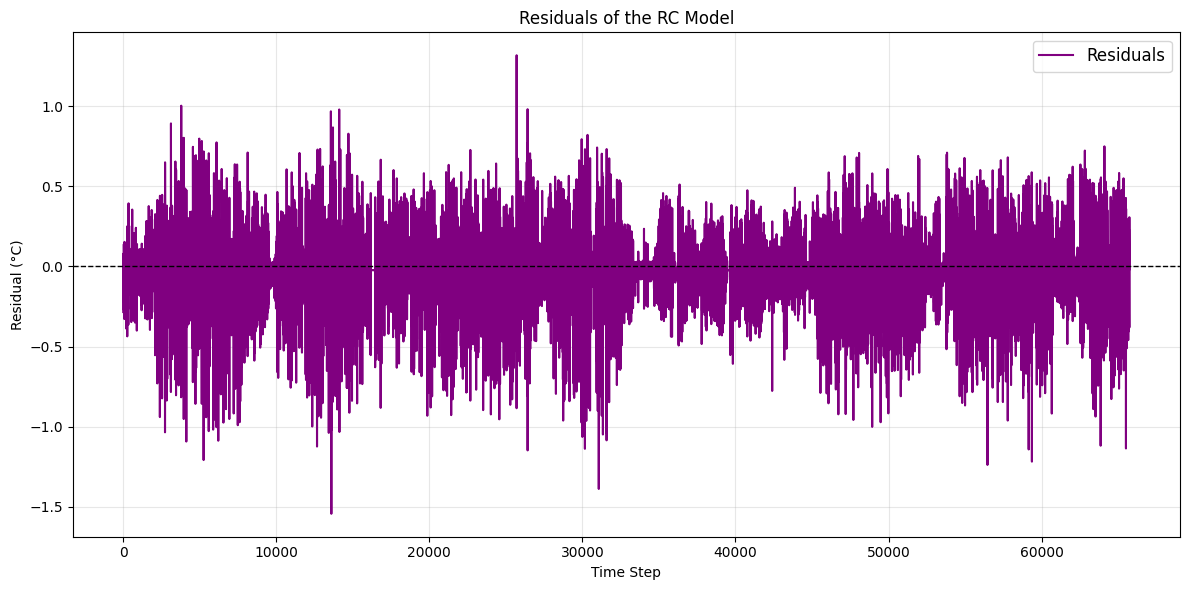


7. Physical interpretation of the model:
Building thermal time constant: 999.50 hours
Building thermal capacity factor: 0.000000
HVAC power influence factor: 0.000011


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(filenames):
    dataframes = {}
    
    for file in filenames:
        try:
            # Read CSV file
            df = pd.read_csv(file, parse_dates=["datetime"])
            
            # Check and handle missing values
            df = df.dropna()
            
            # Check and remove duplicate values
            duplicates = df.duplicated(subset=["datetime"], keep='first')
            if duplicates.sum() > 0:
                df = df.drop_duplicates(subset=["datetime"], keep='first')
            
            # Sort by time
            df = df.sort_values(by="datetime")
            
            # Store processed data
            dataframes[file.split('.')[0]] = df
            
            
        except Exception as e:
            print(f"Unable to process {file}: {e}")
    
    return dataframes

# 2. Resample data to uniform time intervals
def resample_data(dataframes, freq='1H'):
    resampled_data = {}
    
    for name, df in dataframes.items():
        # Set datetime as index
        df_indexed = df.set_index('datetime')
        
        # Resample to specified frequency
        resampled = df_indexed.resample(freq).mean()
        
        # Handle missing values after resampling        
        # Interpolate missing values (using linear interpolation)
        resampled_interp = resampled.interpolate(method='linear')
        
        resampled_data[name] = resampled_interp
    
    return resampled_data

# 3. Align timestamps across different datasets
def align_datasets(resampled_data):
    # Find common time range across all datasets
    start_times = [df.index.min() for df in resampled_data.values()]
    end_times = [df.index.max() for df in resampled_data.values()]
    
    common_start = max(start_times)
    common_end = min(end_times)
        
    # Extract data within the common time range
    aligned_data = {}
    for name, df in resampled_data.items():
        aligned_data[name] = df.loc[common_start:common_end]

    return aligned_data

# 4. Outlier detection and handling
def handle_outliers(aligned_data, z_threshold=3):
    cleaned_data = {}
    
    for name, df in aligned_data.items():
        # Calculate Z-scores
        z_scores = np.abs((df['Value'] - df['Value'].mean()) / df['Value'].std())
        
        # Identify outliers
        outliers = z_scores > z_threshold
        outlier_count = outliers.sum()

        if outlier_count > 0:
            # Replace outliers using local linear interpolation
            df_cleaned = df.copy()
            df_cleaned.loc[outliers, 'Value'] = np.nan
            df_cleaned['Value'] = df_cleaned['Value'].interpolate(method='linear')
            cleaned_data[name] = df_cleaned
        else:
            cleaned_data[name] = df
    
    return cleaned_data

# 5. RC model definition (state space representation)
def rc_model(params, T_indoor, T_outdoor, Q_heat, Q_cool, P_hvac, time_delta_hours):
    """
    First-order RC model (thermodynamic model)
    params: [a, c, d] - model parameters
    T_indoor: indoor temperature vector
    T_outdoor: outdoor temperature (not provided, using constant)
    Q_heat: heating energy
    Q_cool: cooling energy
    P_hvac: HVAC power
    time_delta_hours: time step (hours)
    
    Equation: T_indoor(k+1) = a*T_indoor(k) + c*(Q_heat(k) - Q_cool(k)) + d*P_hvac(k)
    """
    a, c, d = params
    T_indoor_next = np.zeros_like(T_indoor[:-1])
    
    for k in range(len(T_indoor) - 1):
        T_indoor_next[k] = a * T_indoor[k] + c * (Q_heat[k] - Q_cool[k]) + d * P_hvac[k]
    
    return T_indoor_next

# 6. Objective function (for optimization)
def objective_function(params, T_indoor, Q_heat, Q_cool, P_hvac, time_delta_hours):
    T_indoor_predicted = rc_model(params, T_indoor, None, Q_heat, Q_cool, P_hvac, time_delta_hours)
    error = T_indoor_predicted - T_indoor[1:len(T_indoor_predicted)+1]
    return np.sum(error**2)  # Least squares method

# 7. Model evaluation function
# In the evaluate_model function, I'll modify the plotting code to make the lines more distinguishable

def evaluate_model(params, T_indoor, Q_heat, Q_cool, P_hvac, time_delta_hours):
    T_indoor_predicted = rc_model(params, T_indoor, None, Q_heat, Q_cool, P_hvac, time_delta_hours)
    actual = T_indoor[1:len(T_indoor_predicted)+1]
    
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((T_indoor_predicted - actual)**2)
    
    # Calculate coefficient of determination (R²)
    ss_tot = np.sum((actual - np.mean(actual))**2)
    ss_res = np.sum((actual - T_indoor_predicted)**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print(f"Model evaluation results:")
    print(f"MSE: {mse:.6f}")
    print(f"R²: {r_squared:.6f}")
    
    # Plot comparison of actual and predicted values with improved visibility
    plt.figure(figsize=(12, 6))
    
    # Actual temperature with thicker line and distinct color
    plt.plot(actual, label='Actual indoor temperature', linewidth=3, color='blue')
    
    # Predicted temperature with different style
    plt.plot(T_indoor_predicted, label='Predicted indoor temperature', linewidth=1, 
             linestyle='--', color='red')
    
    plt.legend(fontsize=12)
    plt.title('RC Model Fitting Results', fontsize=14)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True, alpha=0.3)  # Lighter grid for better visibility
    plt.tight_layout()
    plt.savefig('rc_model_fit.png', dpi=300)  # Higher resolution
    
    return mse, r_squared

# 8. Main execution function
def main():
    # Define files to process
    filenames = [
        "Cooling energy.csv",
        "Heating energy.csv", 
        "HVAC Power.csv", 
        "Indoor ambient temperature.csv",
        "Water flow in radiators.csv"
    ]
    
    # Load and preprocess data
    dataframes = load_and_preprocess_data(filenames)
    
    # Resample data
    resampled_data = resample_data(dataframes, freq='1H')
    
    # Align datasets
    aligned_data = align_datasets(resampled_data)
    
    # Handle outliers
    cleaned_data = handle_outliers(aligned_data)
    
    # Extract data needed for the model
    T_indoor = cleaned_data['Indoor ambient temperature']['Value'].values
    Q_heat = cleaned_data['Heating energy']['Value'].values
    Q_cool = cleaned_data['Cooling energy']['Value'].values
    P_hvac = cleaned_data['HVAC Power']['Value'].values
    
    # Calculate time step (hours)
    time_delta = pd.Series(cleaned_data['Indoor ambient temperature'].index).diff().mode()[0]
    time_delta_hours = time_delta.total_seconds() / 3600
    
    # Fit RC model
    print("\nFitting RC model...")
    
    # Initial parameter guesses [a, c, d]
    initial_params = [0.9, 0.01, 0.001]
    
    # Parameter constraints (a should be less than 1 to ensure system stability)
    bounds = [(0.5, 0.999), (0, 0.2), (-0.01, 0.01)]
    
    # Optimization
    result = optimize.minimize(
        objective_function,
        initial_params,
        args=(T_indoor, Q_heat, Q_cool, P_hvac, time_delta_hours),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    optimal_params = result.x

    # Output final parameters
    a, c, d = optimal_params
    print(f"\nFinal RC model parameters:")
    print(f"a = {a:.6f}")
    print(f"c = {c:.6f}")
    print(f"d = {d:.6f}")
    
    # Evaluate model
    print("\n6. Evaluating model performance...")
    mse, r_squared = evaluate_model(optimal_params, T_indoor, Q_heat, Q_cool, P_hvac, time_delta_hours)
    
    # Physical interpretation of the model
    print("\n7. Physical interpretation of the model:")
    time_constant = -time_delta_hours / np.log(a)
    print(f"Building thermal time constant: {time_constant:.2f} hours")
    print(f"Building thermal capacity factor: {c:.6f}")
    print(f"HVAC power influence factor: {d:.6f}")

        # Evaluate model
    print("\n6. Evaluating model performance...")
    # mse, r_squared = evaluate_model(optimal_params, T_indoor, Q_heat, Q_cool, P_hvac, time_delta_hours)
    
    # 9. Compute and plot residuals
    # Using the RC model to generate predictions
    T_indoor_predicted = rc_model(optimal_params, T_indoor, None, Q_heat, Q_cool, P_hvac, time_delta_hours)
    # Actual indoor temperature values for corresponding prediction time steps
    actual_temperatures = T_indoor[1:len(T_indoor_predicted)+1]
    # Residuals: difference between predicted and actual values
    residuals = T_indoor_predicted - actual_temperatures
    
    # Compute basic statistics of residuals
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    max_residual = np.max(residuals)
    min_residual = np.min(residuals)
    
    print("\nResiduals Statistics:")
    print(f"Mean residual: {mean_residual:.6f}")
    print(f"Standard deviation: {std_residual:.6f}")
    print(f"Max residual: {max_residual:.6f}")
    print(f"Min residual: {min_residual:.6f}")
    
    # Plot residuals versus time step
    plt.figure(figsize=(12,6))
    plt.plot(residuals, label="Residuals", color='purple')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel("Time Step")
    plt.ylabel("Residual (°C)")
    plt.title("Residuals of the RC Model")
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rc_model_residuals.png', dpi=300)  # Save high-resolution image
    plt.show()
    
    # Physical interpretation of the model
    print("\n7. Physical interpretation of the model:")
    time_constant = -time_delta_hours / np.log(a)
    print(f"Building thermal time constant: {time_constant:.2f} hours")
    print(f"Building thermal capacity factor: {c:.6f}")
    print(f"HVAC power influence factor: {d:.6f}")
    
    return optimal_params, mse, r_squared

    
    return optimal_params, mse, r_squared

if __name__ == "__main__":
    optimal_params, mse, r_squared = main()




MPC did not obtain an optimal solution.
MPC did not obtain an optimal solution.
MPC did not obtain an optimal solution.


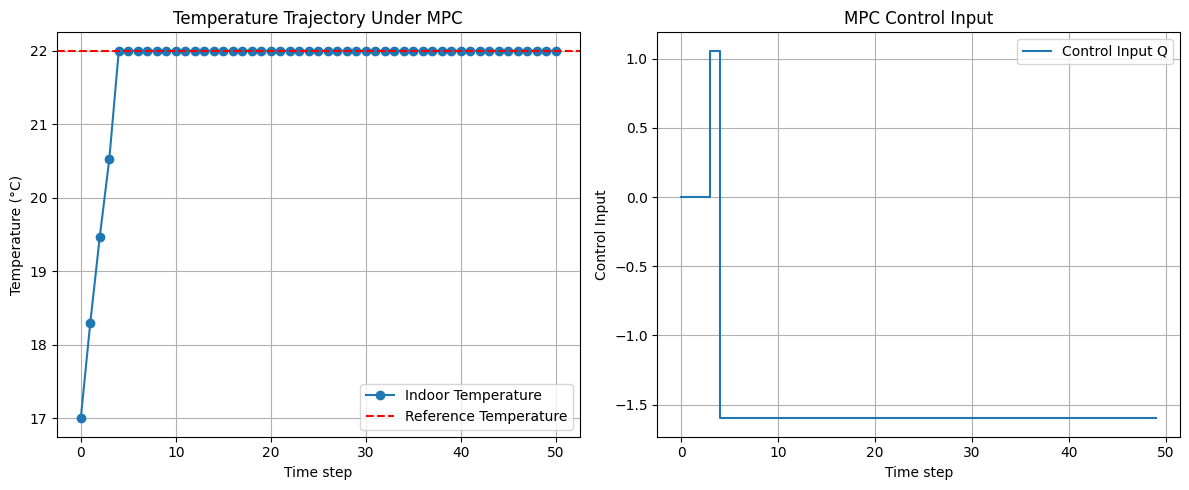

In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Assume these model parameters were obtained from fitting the RC model
a = 0.9     # State transition coefficient
c = 0.5       # Control input coefficient
d = 3      # Constant offset

# MPC parameters
H = 24                 # Prediction horizon (number of time steps)
T_ref = 22.0            # Target reference temperature (°C)
lambda_Q = 0.0          # Weighting factor for the control input

# Control input constraints (assumed units from fitting)
Q_min = -5.0            # Minimum control input (represents cooling)
Q_max = 5.0             # Maximum control input (represents heating)

# Temperature constraints (comfort range)
T_min = 20.0
T_max = 24.0

def mpc_control(T_current):
    """
    Given the current indoor temperature T_current, solve an MPC optimization
    problem to obtain the optimal control input for the current time step.
    
    Returns:
        Q_opt: the optimal control input for the current step
        T_pred: the predicted temperature trajectory over the horizon (for debugging)
    """
    # Define optimization variables:
    Q = cp.Variable(H)       # Sequence of control inputs over the horizon
    T = cp.Variable(H+1)     # Predicted temperature trajectory
    
    # Initial state constraint
    constraints = [T[0] == T_current]
    
    # System dynamics constraints: T[k+1] = a*T[k] + c*Q[k] + d
    for k in range(H):
        constraints += [T[k+1] == a * T[k] + c * Q[k] + d,
                        Q[k] >= Q_min, Q[k] <= Q_max]
    
    # Temperature comfort constraints
    constraints += [T >= T_min, T <= T_max]
    
    # Cost function: Penalize deviation from reference temperature and excessive control input
    cost = 0
    for k in range(1, H+1):
        cost += cp.square(T[k] - T_ref)
    cost += lambda_Q * cp.sum_squares(Q)
    
    # Define and solve the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve()
    
    if problem.status == cp.OPTIMAL:
        # Return the first control input and the predicted temperature trajectory
        return Q.value[0], T.value
    else:
        print("MPC did not obtain an optimal solution.")
        return 0.0, None

# -----------------------------
# MPC closed-loop simulation example
# -----------------------------
sim_time = 50   # Total number of simulation steps
T0 = 17.0       # Initial indoor temperature (°C)
T_traj = [T0]   # List to record temperature trajectory
Q_traj = []     # List to record control inputs

T_current = T0
for t in range(sim_time):
    # Solve MPC to get the optimal control input for the current state
    Q_opt, T_pred = mpc_control(T_current)
    Q_traj.append(Q_opt)
    
    # Update the temperature using the RC model (assuming the model is perfect)
    T_next = a * T_current + c * Q_opt + d
    T_traj.append(T_next)
    T_current = T_next

# Plot the results
plt.figure(figsize=(12, 5))

# Plot temperature trajectory
plt.subplot(1, 2, 1)
plt.plot(T_traj, marker='o', label='Indoor Temperature')
plt.axhline(T_ref, color='r', linestyle='--', label='Reference Temperature')
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trajectory Under MPC")
plt.legend()
plt.grid(True)

# Plot control input trajectory
plt.subplot(1, 2, 2)
plt.step(range(sim_time), Q_traj, where='post', label="Control Input Q")
plt.xlabel("Time step")
plt.ylabel("Control Input")
plt.title("MPC Control Input")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


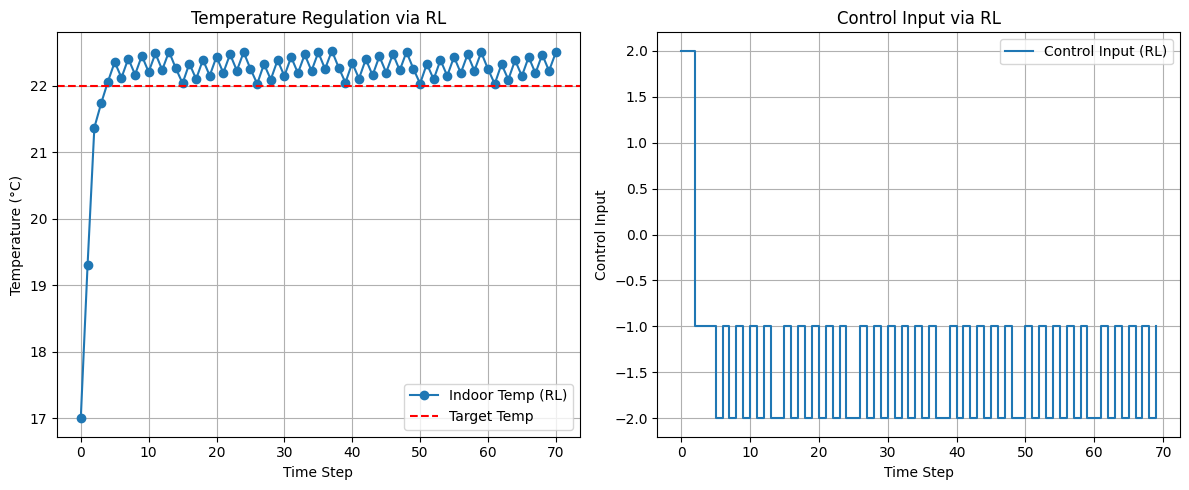

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Environment and model parameters (RC model)
# ------------------------------
a = 0.9     # State transition coefficient
c = 0.5     # Control input coefficient
d = 3       # Constant offset

# Target temperature
T_ref = 22.0

# ------------------------------
# State discretization settings
# ------------------------------
state_min = 10.0   # Lower bound of temperature
state_max = 30.0   # Upper bound of temperature
bin_size = 0.5     # Discretization step size
num_states = int((state_max - state_min) / bin_size) + 1

def discretize_state(T):
    """
    Discretize continuous temperature T into a state index
    """
    idx = int(round((T - state_min) / bin_size))
    idx = max(0, min(idx, num_states - 1))
    return idx

# ------------------------------
# Discrete action space (heating power levels)
# ------------------------------
# Only heating is considered here (positive control). You can modify to include cooling.
actions = [0.0, 0.5, 1, 2, -0.5, -1, -2]
num_actions = len(actions)

# ------------------------------
# Environment dynamics function
# ------------------------------
def environment_step(T, Q):
    """
    Given current temperature T and control input Q, compute the next temperature
    """
    T_next = a * T + c * Q + d
    return T_next

# ------------------------------
# Reward function
# ------------------------------
def reward_function(T):
    """
    Negative squared deviation from the target temperature
    """
    return - (T - T_ref) ** 2

# ------------------------------
# Q-learning parameters
# ------------------------------
episodes = 1000      # Number of training episodes
max_steps = 5       # Max steps per episode
alpha = 0.01         # Learning rate
gamma = 0.90         # Discount factor
epsilon = 1.0        # Initial exploration rate
epsilon_min = 0.01   # Minimum epsilon
epsilon_decay = 0.995  # Epsilon decay rate

# Initialize Q-table [num_states x num_actions]
Q_table = np.zeros((num_states, num_actions))

# ------------------------------
# Q-learning training loop
# ------------------------------
for episode in range(episodes):
    # Random initial temperature between 15°C and 25°C
    T_current = np.random.uniform(15, 25)
    
    for step in range(max_steps):
        s = discretize_state(T_current)
        
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action_index = np.random.randint(num_actions)
        else:
            action_index = np.argmax(Q_table[s])
            
        Q_value = actions[action_index]
        
        # Environment transition
        T_next = environment_step(T_current, Q_value)
        r = reward_function(T_next)
        s_next = discretize_state(T_next)
        
        # Q-value update
        best_next = np.max(Q_table[s_next])
        Q_table[s, action_index] += alpha * (r + gamma * best_next - Q_table[s, action_index])
        
        T_current = T_next
    
    # Decay epsilon after each episode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# ------------------------------
# Evaluation using trained Q-table
# ------------------------------
sim_steps = 70     # Number of steps in simulation
T0 = 17.0          # Initial temperature
T_traj_rl = [T0]   # Store temperature trajectory
Q_traj_rl = []     # Store action trajectory

T_current = T0
for t in range(sim_steps):
    s = discretize_state(T_current)
    best_action_index = np.argmax(Q_table[s])
    Q_opt = actions[best_action_index]
    Q_traj_rl.append(Q_opt)
    
    T_next = environment_step(T_current, Q_opt)
    T_traj_rl.append(T_next)
    T_current = T_next

# ------------------------------
# Plotting the results
# ------------------------------
plt.figure(figsize=(12, 5))

# Plot temperature trajectory
plt.subplot(1, 2, 1)
plt.plot(T_traj_rl, marker='o', label='Indoor Temp (RL)')
plt.axhline(T_ref, color='r', linestyle='--', label='Target Temp')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Regulation via RL")
plt.legend()
plt.grid(True)

# Plot control input trajectory
plt.subplot(1, 2, 2)
plt.step(range(sim_steps), Q_traj_rl, where='post', label='Control Input (RL)')
plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.title("Control Input via RL")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


MPC failed to find optimal solution. Using zero control input.
MPC failed to find optimal solution. Using zero control input.
MPC failed to find optimal solution. Using zero control input.
MPC cumulative squared error: 22.27
RL cumulative squared error: 7.41


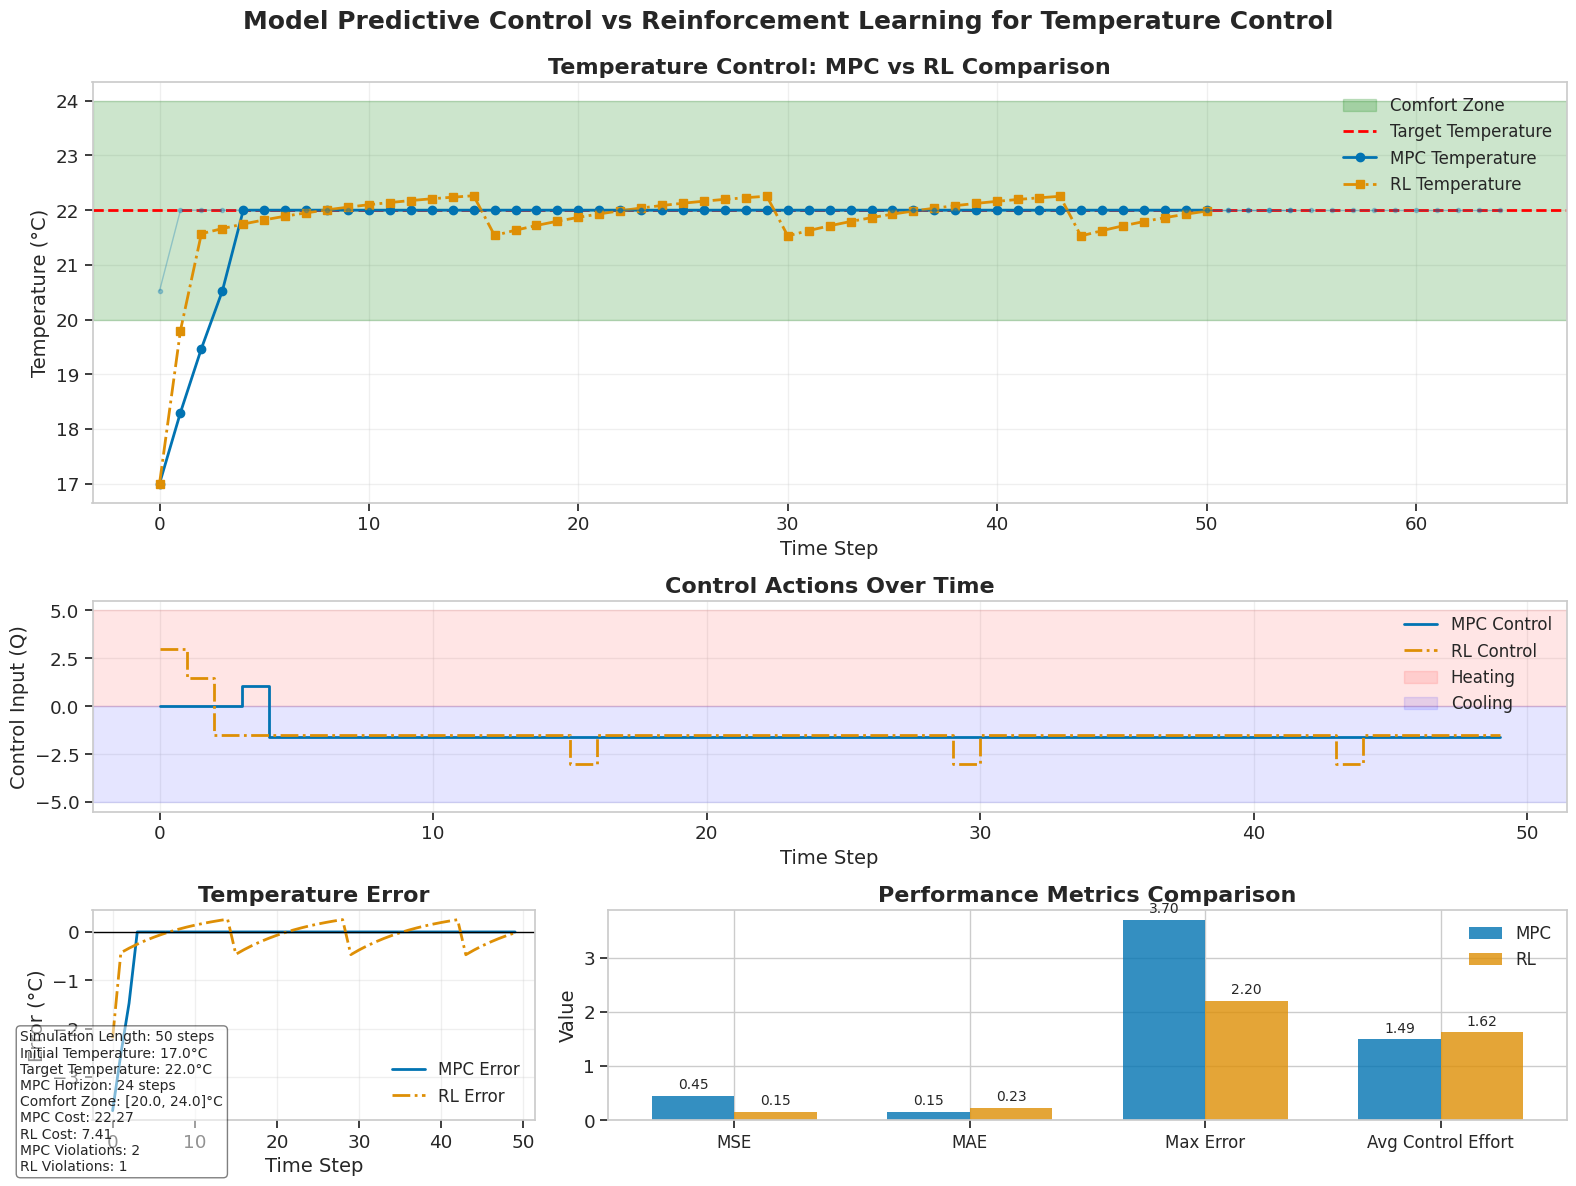

In [6]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

# Set the style for more beautiful visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = sns.color_palette("colorblind")

# Continue with the existing code...
# =============================================================================
# 1. Environment and RC Model Parameters
# =============================================================================
a = 0.9       # State transition coefficient
c = 0.5       # Control input coefficient
d = 3         # System constant offset
T_ref = 22.0  # Target temperature (°C)

# MPC prediction horizon and constraints
H = 24
lambda_Q = 0.0  # Control input penalty weight

# Control input limits (allows both heating and cooling)
Q_min = -5.0  # Minimum control input (cooling)
Q_max = 5.0   # Maximum control input (heating)

# Temperature comfort constraints (used only in MPC)
T_min = 20.0
T_max = 24.0

# =============================================================================
# 2. MPC Controller Implementation
# =============================================================================
def mpc_control(T_current):
    """
    Solve MPC optimization to get the optimal control input for the current state T_current.
    Also return the predicted temperature trajectory (for visualization/debugging).
    """
    Q = cp.Variable(H)
    T = cp.Variable(H+1)

    # Initial condition
    constraints = [T[0] == T_current]

    # System dynamics and input constraints
    for k in range(H):
        constraints += [
            T[k+1] == a * T[k] + c * Q[k] + d,
            Q[k] >= Q_min,
            Q[k] <= Q_max
        ]

    # Temperature constraints
    constraints += [T >= T_min, T <= T_max]

    # Cost function: penalize deviation from target temperature
    cost = 0
    for k in range(1, H+1):
        cost += cp.square(T[k] - T_ref)
    cost += lambda_Q * cp.sum_squares(Q)

    # Solve the optimization problem
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.ECOS)

    if prob.status == cp.OPTIMAL:
        return Q.value[0], T.value
    else:
        print("MPC failed to find optimal solution. Using zero control input.")
        return 0.0, None

# =============================================================================
# 3. RL Controller (Q-learning)
# =============================================================================
# State discretization (temperature range [10, 30] with step size 0.5°C)
state_min = 10.0
state_max = 30.0
bin_size = 0.5
num_states = int((state_max - state_min) / bin_size) + 1

def discretize_state(T):
    """
    Discretize continuous temperature T into state index
    """
    idx = int(round((T - state_min) / bin_size))
    idx = max(0, min(idx, num_states - 1))
    return idx

# Discrete control actions (heating power levels)
actions = [0.0, 1.5, 3, -1.5, -3.0]
num_actions = len(actions)

# Environment transition function
def environment_step(T, Q):
    return a * T + c * Q + d

# Reward function: negative squared temperature deviation
def reward_function(T):
    return - (T - T_ref) ** 2

# Q-learning hyperparameters
episodes = 1000
max_steps = 5
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

# Initialize Q-table [num_states x num_actions]
Q_table = np.zeros((num_states, num_actions))

# Q-learning training loop
for episode in range(episodes):
    T_current = np.random.uniform(15, 25)
    for step in range(max_steps):
        s = discretize_state(T_current)
        if np.random.rand() < epsilon:
            action_index = np.random.randint(num_actions)
        else:
            action_index = np.argmax(Q_table[s])
        Q_val = actions[action_index]

        T_next = environment_step(T_current, Q_val)
        r = reward_function(T_next)
        s_next = discretize_state(T_next)

        best_next = np.max(Q_table[s_next])
        Q_table[s, action_index] += alpha * (r + gamma * best_next - Q_table[s, action_index])

        T_current = T_next

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# =============================================================================
# 4. Closed-loop Simulation Comparison of MPC vs RL
# =============================================================================
sim_time = 50
T0 = 17.0

# Store prediction horizons for MPC visualization
mpc_prediction_horizons = []

# -------------------------------
# MPC simulation
# -------------------------------
T_traj_mpc = [T0]
Q_traj_mpc = []

T_current = T0
for t in range(sim_time):
    Q_opt, predicted_temps = mpc_control(T_current)
    # Store the MPC prediction at each step for visualization
    if predicted_temps is not None:
        mpc_prediction_horizons.append(predicted_temps)
    Q_traj_mpc.append(Q_opt)
    T_next = environment_step(T_current, Q_opt)
    T_traj_mpc.append(T_next)
    T_current = T_next

# -------------------------------
# RL simulation
# -------------------------------
T_traj_rl = [T0]
Q_traj_rl = []

T_current = T0
for t in range(sim_time):
    s = discretize_state(T_current)
    best_action_index = np.argmax(Q_table[s])
    Q_opt = actions[best_action_index]
    Q_traj_rl.append(Q_opt)
    T_next = environment_step(T_current, Q_opt)
    T_traj_rl.append(T_next)
    T_current = T_next

# -------------------------------
# Compute performance (cumulative squared error)
# -------------------------------
def compute_cost(T_traj):
    error = np.array(T_traj[1:]) - T_ref
    return np.sum(error**2)

cost_mpc = compute_cost(T_traj_mpc)
cost_rl = compute_cost(T_traj_rl)

print("MPC cumulative squared error: {:.2f}".format(cost_mpc))
print("RL cumulative squared error: {:.2f}".format(cost_rl))

# =============================================================================
# 5. Enhanced Visualizations
# =============================================================================

# Function to compute metrics for performance comparison
def compute_performance_metrics(T_traj, Q_traj):
    # Temperature error metrics
    error = np.array(T_traj[1:]) - T_ref
    abs_error = np.abs(error)
    mse = np.mean(error**2)
    mae = np.mean(abs_error)
    max_error = np.max(abs_error)
    
    # Control effort
    total_control_effort = np.sum(np.abs(Q_traj))
    avg_control_effort = np.mean(np.abs(Q_traj))
    
    # Comfort violation (outside of [T_min, T_max])
    violations = np.sum((np.array(T_traj[1:]) < T_min) | (np.array(T_traj[1:]) > T_max))
    
    return {
        'MSE': mse,
        'MAE': mae,
        'Max Error': max_error,
        'Total Control Effort': total_control_effort,
        'Avg Control Effort': avg_control_effort,
        'Comfort Violations': violations
    }

# Compute performance metrics
mpc_metrics = compute_performance_metrics(T_traj_mpc, Q_traj_mpc)
rl_metrics = compute_performance_metrics(T_traj_rl, Q_traj_rl)

# Create a figure with a custom layout
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, height_ratios=[2, 1, 1], figure=fig)

# 1. Main temperature trajectory plot
ax1 = fig.add_subplot(gs[0, :])
time_steps = np.arange(sim_time + 1)

# Temperature comfort zone as shaded area
ax1.axhspan(T_min, T_max, alpha=0.2, color='green', label='Comfort Zone')

# Target temperature as line
ax1.axhline(T_ref, color='red', linestyle='--', linewidth=2, label='Target Temperature')

# Plot temperature trajectories
mpc_line, = ax1.plot(time_steps, T_traj_mpc, marker='o', markersize=6, linewidth=2, 
                    color=colors[0], label='MPC Temperature')
rl_line, = ax1.plot(time_steps, T_traj_rl, marker='s', markersize=6, linewidth=2, 
                   linestyle='-.', color=colors[1], label='RL Temperature')

# MPC prediction horizons visualization for selected time steps (every 10 steps)
for i in range(0, sim_time, 10):
    if i < len(mpc_prediction_horizons):
        horizon_times = np.arange(i, i + len(mpc_prediction_horizons[i]))
        ax1.plot(horizon_times, mpc_prediction_horizons[i], 'o-', color=colors[0], 
                alpha=0.3, linewidth=1, markersize=3)

ax1.set_xlabel('Time Step', fontsize=14)
ax1.set_ylabel('Temperature (°C)', fontsize=14)
ax1.set_title('Temperature Control: MPC vs RL Comparison', fontsize=16, fontweight='bold')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Control input subplot
ax2 = fig.add_subplot(gs[1, :])
ax2.step(np.arange(sim_time), Q_traj_mpc, where='post', linewidth=2, 
        color=colors[0], label='MPC Control')
ax2.step(np.arange(sim_time), Q_traj_rl, where='post', linewidth=2, 
        linestyle='-.', color=colors[1], label='RL Control')

# Mark heating and cooling regions
ax2.axhspan(0, Q_max, alpha=0.1, color='red', label='Heating')
ax2.axhspan(Q_min, 0, alpha=0.1, color='blue', label='Cooling')

ax2.set_xlabel('Time Step', fontsize=14)
ax2.set_ylabel('Control Input (Q)', fontsize=14)
ax2.set_title('Control Actions Over Time', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)

# 3. Error plot (deviation from target temperature)
ax3 = fig.add_subplot(gs[2, 0])
mpc_error = np.array(T_traj_mpc[1:]) - T_ref
rl_error = np.array(T_traj_rl[1:]) - T_ref

ax3.plot(np.arange(sim_time), mpc_error, linewidth=2, color=colors[0], label='MPC Error')
ax3.plot(np.arange(sim_time), rl_error, linewidth=2, linestyle='-.', color=colors[1], label='RL Error')
ax3.axhline(0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Time Step', fontsize=14)
ax3.set_ylabel('Error (°C)', fontsize=14)
ax3.set_title('Temperature Error', fontsize=16, fontweight='bold')
ax3.legend(fontsize=12)
ax3.grid(True, alpha=0.3)

# 4. Performance metrics comparison
ax4 = fig.add_subplot(gs[2, 1:])
metrics_names = ['MSE', 'MAE', 'Max Error', 'Avg Control Effort']
mpc_values = [mpc_metrics[m] for m in metrics_names]
rl_values = [rl_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

bar1 = ax4.bar(x - width/2, mpc_values, width, label='MPC', color=colors[0], alpha=0.8)
bar2 = ax4.bar(x + width/2, rl_values, width, label='RL', color=colors[1], alpha=0.8)

ax4.set_ylabel('Value', fontsize=14)
ax4.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_names, fontsize=12)
ax4.legend(fontsize=12)

# Add value labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bar1)
add_labels(bar2)

# Add a summary text box
textstr = '\n'.join((
    f'Simulation Length: {sim_time} steps',
    f'Initial Temperature: {T0:.1f}°C',
    f'Target Temperature: {T_ref:.1f}°C',
    f'MPC Horizon: {H} steps',
    f'Comfort Zone: [{T_min:.1f}, {T_max:.1f}]°C',
    f'MPC Cost: {cost_mpc:.2f}',
    f'RL Cost: {cost_rl:.2f}',
    f'MPC Violations: {mpc_metrics["Comfort Violations"]}',
    f'RL Violations: {rl_metrics["Comfort Violations"]}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
fig.text(0.02, 0.02, textstr, fontsize=10,
        verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.suptitle('Model Predictive Control vs Reinforcement Learning for Temperature Control', 
            fontsize=18, fontweight='bold', y=0.99)
plt.subplots_adjust(top=0.93)

# =============================================================================
# 6. Heatmap Visualization of Q-table (RL Policy)
# =============================================================================

# plt.figure(figsize=(14, 6))

# # Create a temperature range for X-axis
# temp_values = np.linspace(state_min, state_max, num_states)

# # Get the action with highest Q-value for each state
# best_actions = np.argmax(Q_table, axis=1)
# best_action_values = [actions[i] for i in best_actions]

# # Create a heatmap of the Q-table
# plt.subplot(1, 2, 1)
# sns.heatmap(Q_table, cmap='viridis', 
#            xticklabels=[f"{a:.1f}" for a in actions],
#            yticklabels=[f"{t:.1f}" if i % 4 == 0 else "" for i, t in enumerate(temp_values)],
#            cbar_kws={'label': 'Q-Value'})
# plt.xlabel('Action (Control Input)', fontsize=12)
# plt.ylabel('State (Temperature °C)', fontsize=12)
# plt.title('Q-Table Heatmap', fontsize=14)

# Create a policy visualization
# plt.subplot(1, 2, 2)
# plt.plot(temp_values, best_action_values, 'o-', linewidth=2)
# plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
# plt.axvline(x=T_ref, color='r', linestyle='--', label='Target Temp')
# plt.grid(True, alpha=0.3)
# plt.xlabel('Temperature (°C)', fontsize=12)
# plt.ylabel('Best Control Action', fontsize=12)
# plt.title('RL Policy Function', fontsize=14)
# plt.legend()

# plt.tight_layout()
# plt.suptitle('RL Controller Analysis', fontsize=16, y=1.02)

# =============================================================================
# 7. Create an animation of the system response
# =============================================================================
# Uncomment this section if you want to generate an animation (requires matplotlib animation)

# from matplotlib.animation import FuncAnimation

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# fig.suptitle('Temperature Control Simulation', fontsize=16)

# # Set up the temperature plot
# ax1.set_xlim(0, sim_time)
# ax1.set_ylim(min(min(T_traj_mpc), min(T_traj_rl))-1, max(max(T_traj_mpc), max(T_traj_rl))+1)
# ax1.axhspan(T_min, T_max, alpha=0.2, color='green', label='Comfort Zone')
# ax1.axhline(T_ref, color='red', linestyle='--', label='Target')
# ax1.set_ylabel('Temperature (°C)')
# ax1.legend()

# # Set up the control input plot
# ax2.set_xlim(0, sim_time)
# ax2.set_ylim(Q_min-0.5, Q_max+0.5)
# ax2.axhspan(0, Q_max, alpha=0.1, color='red', label='Heating')
# ax2.axhspan(Q_min, 0, alpha=0.1, color='blue', label='Cooling')
# ax2.set_xlabel('Time Step')
# ax2.set_ylabel('Control Input')
# ax2.legend()

# # Initialize lines
# line_mpc_temp, = ax1.plot([], [], 'o-', label='MPC')
# line_rl_temp, = ax1.plot([], [], 's-', label='RL')
# line_mpc_control, = ax2.plot([], [], 'o-')
# line_rl_control, = ax2.plot([], [], 's-')

# def init():
#     line_mpc_temp.set_data([], [])
#     line_rl_temp.set_data([], [])
#     line_mpc_control.set_data([], [])
#     line_rl_control.set_data([], [])
#     return line_mpc_temp, line_rl_temp, line_mpc_control, line_rl_control

# def animate(i):
#     # Plot only up to the current frame
#     x_temp = np.arange(i+2)  # +2 because we have initial temperature
#     y_mpc_temp = T_traj_mpc[:i+2]
#     y_rl_temp = T_traj_rl[:i+2]
    
#     x_control = np.arange(i+1)
#     y_mpc_control = Q_traj_mpc[:i+1]
#     y_rl_control = Q_traj_rl[:i+1]
    
#     line_mpc_temp.set_data(x_temp, y_mpc_temp)
#     line_rl_temp.set_data(x_temp, y_rl_temp)
#     line_mpc_control.set_data(x_control, y_mpc_control)
#     line_rl_control.set_data(x_control, y_rl_control)
    
#     return line_mpc_temp, line_rl_temp, line_mpc_control, line_rl_control

# # Create animation
# ani = FuncAnimation(fig, animate, frames=sim_time, init_func=init, blit=True, interval=200)

# # Save animation (requires ffmpeg)
# ani.save('temperature_control_simulation.mp4', writer='ffmpeg', fps=5, dpi=100)


# # Display all plots
# plt.show()

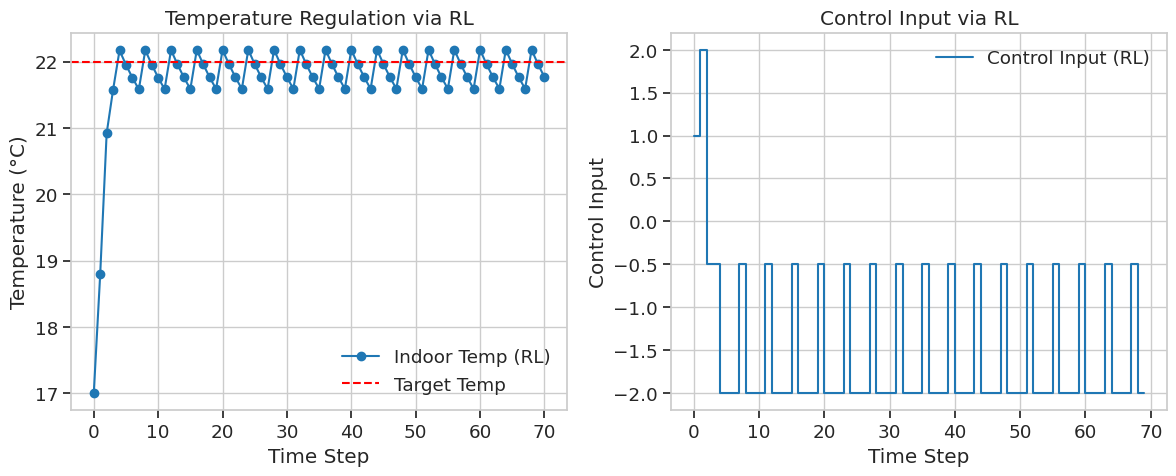

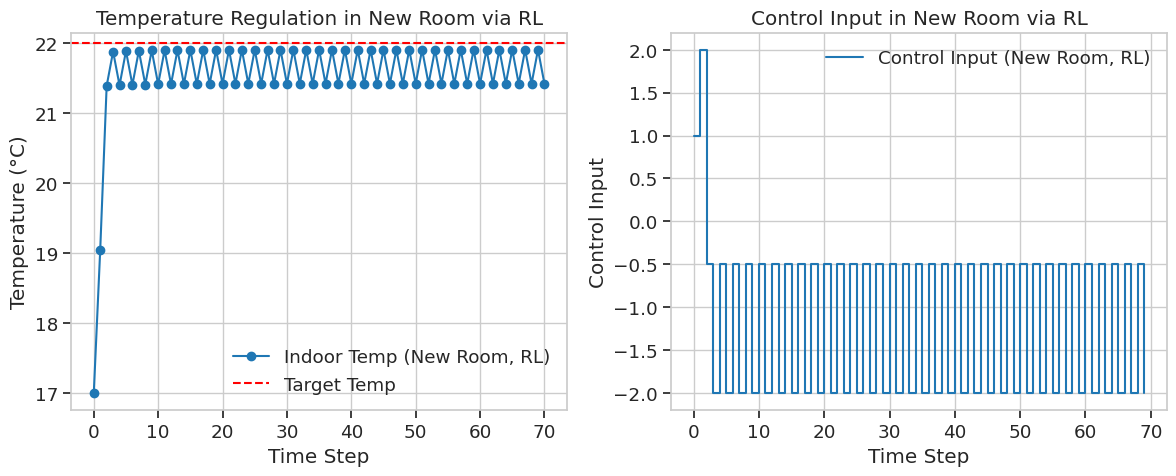

In [7]:

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Environment and model parameters (RC model)
# ------------------------------
a = 0.9     # State transition coefficient
c = 0.5     # Control input coefficient
d = 3       # Constant offset

# Target temperature
T_ref = 22.0

# ------------------------------
# State discretization settings
# ------------------------------
state_min = 10.0   # Lower bound of temperature
state_max = 30.0   # Upper bound of temperature
bin_size = 0.5     # Discretization step size
num_states = int((state_max - state_min) / bin_size) + 1

def discretize_state(T):
    """
    Discretize continuous temperature T into a state index
    """
    idx = int(round((T - state_min) / bin_size))
    idx = max(0, min(idx, num_states - 1))
    return idx

# ------------------------------
# Discrete action space (heating power levels)
# ------------------------------
# Only heating is considered here (positive control). You can modify to include cooling.
actions = [0.0, 0.5, 1, 2, -0.5, -1, -2]
num_actions = len(actions)

# ------------------------------
# Environment dynamics function
# ------------------------------
def environment_step(T, Q):
    """
    Given current temperature T and control input Q, compute the next temperature
    """
    T_next = a * T + c * Q + d
    return T_next

# ------------------------------
# Reward function
# ------------------------------
def reward_function(T):
    """
    Negative squared deviation from the target temperature
    """
    return - (T - T_ref) ** 2

# ------------------------------
# Q-learning parameters
# ------------------------------
episodes = 1000      # Number of training episodes
max_steps = 5       # Max steps per episode
alpha = 0.01         # Learning rate
gamma = 0.90         # Discount factor
epsilon = 1.0        # Initial exploration rate
epsilon_min = 0.01   # Minimum epsilon
epsilon_decay = 0.995  # Epsilon decay rate

# Initialize Q-table [num_states x num_actions]
Q_table = np.zeros((num_states, num_actions))

# ------------------------------
# Q-learning training loop
# ------------------------------
for episode in range(episodes):
    # Random initial temperature between 15°C and 25°C
    T_current = np.random.uniform(15, 25)
    
    for step in range(max_steps):
        s = discretize_state(T_current)
        
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action_index = np.random.randint(num_actions)
        else:
            action_index = np.argmax(Q_table[s])
            
        Q_value = actions[action_index]
        
        # Environment transition
        T_next = environment_step(T_current, Q_value)
        r = reward_function(T_next)
        s_next = discretize_state(T_next)
        
        # Q-value update
        best_next = np.max(Q_table[s_next])
        Q_table[s, action_index] += alpha * (r + gamma * best_next - Q_table[s, action_index])
        
        T_current = T_next
    
    # Decay epsilon after each episode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# ------------------------------
# Evaluation using trained Q-table
# ------------------------------
sim_steps = 70     # Number of steps in simulation
T0 = 17.0          # Initial temperature
T_traj_rl = [T0]   # Store temperature trajectory
Q_traj_rl = []     # Store action trajectory

T_current = T0
for t in range(sim_steps):
    s = discretize_state(T_current)
    best_action_index = np.argmax(Q_table[s])
    Q_opt = actions[best_action_index]
    Q_traj_rl.append(Q_opt)
    
    T_next = environment_step(T_current, Q_opt)
    T_traj_rl.append(T_next)
    T_current = T_next

# ------------------------------
# Plotting the results
# ------------------------------
plt.figure(figsize=(12, 5))

# Plot temperature trajectory
plt.subplot(1, 2, 1)
plt.plot(T_traj_rl, marker='o', label='Indoor Temp (RL)')
plt.axhline(T_ref, color='r', linestyle='--', label='Target Temp')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Regulation via RL")
plt.legend()
plt.grid(True)

# Plot control input trajectory
plt.subplot(1, 2, 2)
plt.step(range(sim_steps), Q_traj_rl, where='post', label='Control Input (RL)')
plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.title("Control Input via RL")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ------------------------------
# Evaluation on a new room with different dynamics parameters
# ------------------------------

# New room dynamics parameters (changed dynamics)
new_a = 0.85    # New state transition coefficient for the new room
new_c = 0.6     # New control input coefficient for the new room
new_d = 4       # New constant offset for the new room

def environment_step_new(T, Q):
    """
    Compute the next temperature for a new room using different dynamics parameters.
    """
    T_next = new_a * T + new_c * Q + new_d
    return T_next

# Simulation settings for the new room
sim_steps_new = 70     # Number of simulation steps for the new room
T0_new = 17.0          # Initial temperature for the new room
T_traj_new = [T0_new]  # List to store the temperature trajectory in the new room
Q_traj_new = []        # List to store the control input trajectory in the new room

# Run simulation on the new room using the trained Q-table
T_current_new = T0_new
for t in range(sim_steps_new):
    s_new = discretize_state(T_current_new)
    best_action_index_new = np.argmax(Q_table[s_new])  # Use trained Q_table from original room
    Q_opt_new = actions[best_action_index_new]
    Q_traj_new.append(Q_opt_new)
    
    T_next_new = environment_step_new(T_current_new, Q_opt_new)
    T_traj_new.append(T_next_new)
    T_current_new = T_next_new

# ------------------------------
# Plotting the results for the new room
# ------------------------------
plt.figure(figsize=(12, 5))

# Plot temperature trajectory for the new room
plt.subplot(1, 2, 1)
plt.plot(T_traj_new, marker='o', label='Indoor Temp (New Room, RL)')
plt.axhline(T_ref, color='r', linestyle='--', label='Target Temp')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Regulation in New Room via RL")
plt.legend()
plt.grid(True)

# Plot control input trajectory for the new room
plt.subplot(1, 2, 2)
plt.step(range(sim_steps_new), Q_traj_new, where='post', label='Control Input (New Room, RL)')
plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.title("Control Input in New Room via RL")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Training Q-learning agent on original environment...
Episode 100/1000, Avg Reward: -9.74, Epsilon: 0.6058
Episode 200/1000, Avg Reward: -3.64, Epsilon: 0.3670
Episode 300/1000, Avg Reward: -1.25, Epsilon: 0.2223
Episode 400/1000, Avg Reward: -0.06, Epsilon: 0.1347
Episode 500/1000, Avg Reward: -0.03, Epsilon: 0.0816
Episode 600/1000, Avg Reward: -1.45, Epsilon: 0.0494
Episode 700/1000, Avg Reward: -0.10, Epsilon: 0.0299
Episode 800/1000, Avg Reward: -5.22, Epsilon: 0.0181
Episode 900/1000, Avg Reward: -2.14, Epsilon: 0.0110
Episode 1000/1000, Avg Reward: -0.52, Epsilon: 0.0100
Evaluating on Original Room...
  Avg Reward: -0.19
  Steady State Error: 0.38°C
  Stability (Std Dev): 0.1512
Evaluating on High Inertia Room...
  Avg Reward: -4.21
  Steady State Error: 2.85°C
  Stability (Std Dev): 0.1120
Evaluating on Low Inertia Room...
  Avg Reward: -1.49
  Steady State Error: 0.98°C
  Stability (Std Dev): 0.3144
Evaluating on Differently Insulated Room...
  Avg Reward: -0.63
  Steady State 

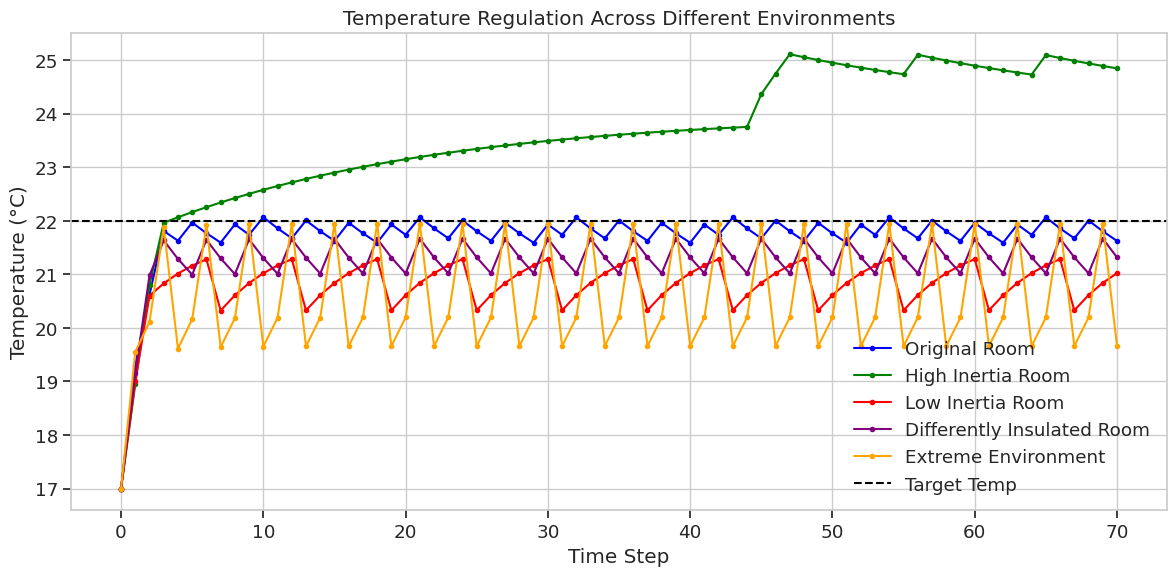

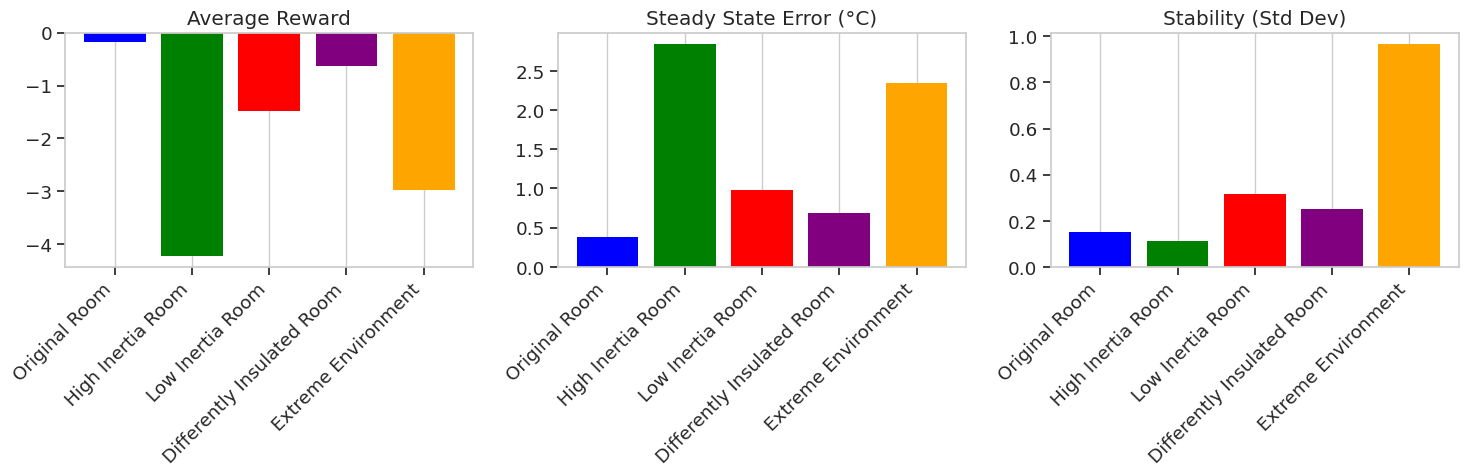

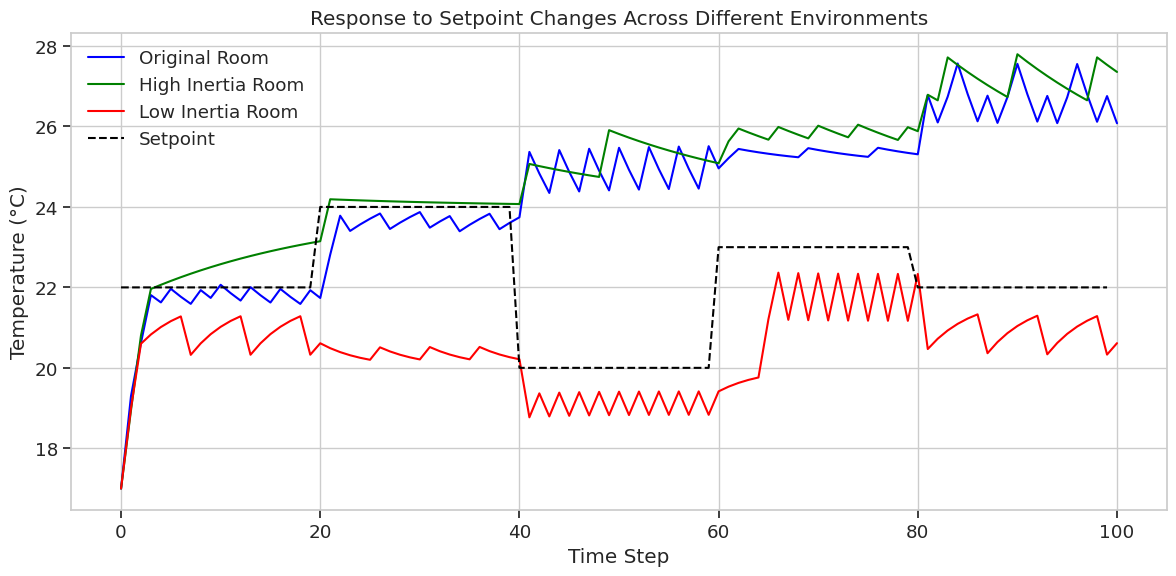

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------
# Environment and model parameters (RC model)
# ------------------------------
a = 0.9     # State transition coefficient
c = 0.5     # Control input coefficient
d = 3       # Constant offset

# Target temperature
T_ref = 22.0

# ------------------------------
# State discretization settings
# ------------------------------
state_min = 10.0   # Lower bound of temperature
state_max = 30.0   # Upper bound of temperature
bin_size = 0.5     # Discretization step size
num_states = int((state_max - state_min) / bin_size) + 1

def discretize_state(T):
    """
    Discretize continuous temperature T into a state index
    """
    idx = int(round((T - state_min) / bin_size))
    idx = max(0, min(idx, num_states - 1))
    return idx

def continuous_state(idx):
    """
    Convert state index back to continuous temperature
    """
    return state_min + idx * bin_size

# ------------------------------
# Discrete action space (heating power levels)
# ------------------------------
# Both heating and cooling are considered here
actions = [0.0, 0.5, 1, 2, -0.5, -1, -2]
num_actions = len(actions)

# ------------------------------
# Environment dynamics function
# ------------------------------
def environment_step(T, Q, params):
    """
    Given current temperature T and control input Q, compute the next temperature
    using specified dynamics parameters
    """
    a_val, c_val, d_val = params
    T_next = a_val * T + c_val * Q + d_val
    return T_next

# ------------------------------
# Reward function
# ------------------------------
def reward_function(T):
    """
    Negative squared deviation from the target temperature
    """
    return - (T - T_ref) ** 2

# ------------------------------
# Q-learning parameters
# ------------------------------
episodes = 1000      # Number of training episodes
max_steps = 5       # Max steps per episode
alpha = 0.01         # Learning rate
gamma = 0.90         # Discount factor
epsilon = 1.0        # Initial exploration rate
epsilon_min = 0.01   # Minimum epsilon
epsilon_decay = 0.995  # Epsilon decay rate

# Original room parameters
orig_params = (a, c, d)

# Initialize Q-table [num_states x num_actions]
Q_table = np.zeros((num_states, num_actions))

# ------------------------------
# Q-learning training loop
# ------------------------------
print("Training Q-learning agent on original environment...")
rewards_per_episode = []

for episode in range(episodes):
    # Random initial temperature between 15°C and 25°C
    T_current = np.random.uniform(15, 25)
    episode_reward = 0
    
    for step in range(max_steps):
        s = discretize_state(T_current)
        
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action_index = np.random.randint(num_actions)
        else:
            action_index = np.argmax(Q_table[s])
            
        Q_value = actions[action_index]
        
        # Environment transition
        T_next = environment_step(T_current, Q_value, orig_params)
        r = reward_function(T_next)
        episode_reward += r
        s_next = discretize_state(T_next)
        
        # Q-value update
        best_next = np.max(Q_table[s_next])
        Q_table[s, action_index] += alpha * (r + gamma * best_next - Q_table[s, action_index])
        
        T_current = T_next
    
    rewards_per_episode.append(episode_reward / max_steps)
    
    # Decay epsilon after each episode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        
    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes}, Avg Reward: {episode_reward/max_steps:.2f}, Epsilon: {epsilon:.4f}")

# ------------------------------
# Define a function to evaluate policy on different environments
# ------------------------------
def evaluate_policy(params, initial_temp=17.0, steps=70):
    """
    Evaluate the trained policy on an environment with specified dynamics parameters
    """
    T_traj = [initial_temp]
    Q_traj = []
    rewards = []
    
    T_current = initial_temp
    for t in range(steps):
        s = discretize_state(T_current)
        best_action_index = np.argmax(Q_table[s])
        Q_opt = actions[best_action_index]
        Q_traj.append(Q_opt)
        
        T_next = environment_step(T_current, Q_opt, params)
        reward = reward_function(T_next)
        rewards.append(reward)
        T_traj.append(T_next)
        T_current = T_next
    
    # Calculate performance metrics
    avg_reward = np.mean(rewards)
    steady_state_err = abs(T_traj[-1] - T_ref)
    stability = np.std(T_traj[-10:])  # Stability in last 10 steps
    
    return {
        'temp_trajectory': T_traj,
        'control_trajectory': Q_traj,
        'rewards': rewards,
        'avg_reward': avg_reward,
        'steady_state_error': steady_state_err,
        'stability': stability
    }

# ------------------------------
# Define multiple environment parameter sets for comparison
# ------------------------------
# Original environment
env1 = {
    'name': 'Original Room',
    'params': (0.9, 0.5, 3),
    'color': 'blue'
}

# Environments with different dynamics - varied thermal inertia
env2 = {
    'name': 'High Inertia Room',
    'params': (0.95, 0.4, 2),  # Higher a, lower c, lower d
    'color': 'green'
}

env3 = {
    'name': 'Low Inertia Room',
    'params': (0.8, 0.7, 4),   # Lower a, higher c, higher d
    'color': 'red'
}

env4 = {
    'name': 'Differently Insulated Room',
    'params': (0.85, 0.6, 3.5),  # Different combination of parameters
    'color': 'purple'
}

env5 = {
    'name': 'Extreme Environment',
    'params': (0.75, 0.9, 5),  # Very different dynamics
    'color': 'orange'
}

# List of environments to evaluate
environments = [env1, env2, env3, env4, env5]

# ------------------------------
# Evaluate the trained policy on all environments
# ------------------------------
results = {}
for env in environments:
    print(f"Evaluating on {env['name']}...")
    results[env['name']] = evaluate_policy(env['params'])
    print(f"  Avg Reward: {results[env['name']]['avg_reward']:.2f}")
    print(f"  Steady State Error: {results[env['name']]['steady_state_error']:.2f}°C")
    print(f"  Stability (Std Dev): {results[env['name']]['stability']:.4f}")

# ------------------------------
# Visualization 1: Temperature trajectories across environments
# ------------------------------
plt.figure(figsize=(12, 6))
for env in environments:
    env_name = env['name']
    temp_traj = results[env_name]['temp_trajectory']
    plt.plot(temp_traj, marker='.', label=env_name, color=env['color'])

plt.axhline(T_ref, color='k', linestyle='--', label='Target Temp')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Regulation Across Different Environments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('temperature_comparison.png')

# ------------------------------
# Visualization 3: Performance metrics comparison
# ------------------------------
# Create a bar chart to compare performance metrics
metrics = ['avg_reward', 'steady_state_error', 'stability']
metric_names = ['Average Reward', 'Steady State Error (°C)', 'Stability (Std Dev)']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    values = [results[env['name']][metric] for env in environments]
    names = [env['name'] for env in environments]
    colors = [env['color'] for env in environments]
    
    axes[i].bar(names, values, color=colors)
    axes[i].set_title(metric_name)
    axes[i].set_xticklabels(names, rotation=45, ha='right')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.savefig('performance_metrics.png')



# ------------------------------
# Visualization 8: Temperature response with setpoint changes
# ------------------------------
def simulate_setpoint_changes(params, setpoint_schedule):
    """
    Simulate policy response to changing temperature setpoints
    """
    steps = len(setpoint_schedule)
    T_traj = [17.0]  # Start with initial temperature
    Q_traj = []
    setpoints = []
    
    T_current = 17.0
    for t in range(steps):
        # Current setpoint
        T_ref_current = setpoint_schedule[t]
        setpoints.append(T_ref_current)
        
        # Get state and action
        s = discretize_state(T_current)
        
        # Adjust reward function for current setpoint (hack to make policy work with different setpoints)
        # We calculate the equivalent state as if the setpoint were still 22°C
        temp_diff = T_current - T_ref_current
        equivalent_temp = 22.0 + temp_diff
        equivalent_state = discretize_state(equivalent_temp)
        
        # Get action from equivalent state
        best_action_index = np.argmax(Q_table[equivalent_state])
        Q_opt = actions[best_action_index]
        Q_traj.append(Q_opt)
        
        # Apply action in actual environment
        T_next = environment_step(T_current, Q_opt, params)
        T_traj.append(T_next)
        T_current = T_next
    
    return T_traj, Q_traj, setpoints

# Create setpoint schedule (changing temperature targets)
steps = 100
setpoint_schedule = np.ones(steps) * 22.0  # Default setpoint

# Change setpoints at specific times
setpoint_schedule[20:40] = 24.0  # Increase setpoint to 24°C
setpoint_schedule[40:60] = 20.0  # Decrease setpoint to 20°C
setpoint_schedule[60:80] = 23.0  # Set to 23°C
setpoint_schedule[80:] = 22.0    # Back to default 22°C

# Run simulation with setpoint changes
plt.figure(figsize=(12, 6))

for env in environments[:3]:  # Limit to 3 environments for clarity
    T_traj, Q_traj, setpoints = simulate_setpoint_changes(env['params'], setpoint_schedule)
    plt.plot(T_traj, label=f"{env['name']}", color=env['color'])

plt.plot(setpoints, 'k--', label='Setpoint')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.title('Response to Setpoint Changes Across Different Environments')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('setpoint_changes.png')


Creating MPC controller with original environment model...
Evaluating MPC on Original Room...
  Avg Reward: -0.11
  Steady State Error: 0.03°C
  Stability (Std Dev): 0.0000
Evaluating MPC on High Inertia Room...
  Avg Reward: -2.51
  Steady State Error: 1.94°C
  Stability (Std Dev): 0.0110
Evaluating MPC on Low Inertia Room...
  Avg Reward: -2.09
  Steady State Error: 1.41°C
  Stability (Std Dev): 0.0000
Evaluating MPC on Differently Insulated Room...
  Avg Reward: -0.80
  Steady State Error: 0.83°C
  Stability (Std Dev): 0.0000
Evaluating MPC on Extreme Environment...
  Avg Reward: -2.03
  Steady State Error: 1.41°C
  Stability (Std Dev): 0.0000


Evaluating MPC with perfect model on Original Room...
  Steady State Error with transferred model: 0.0311°C
  Steady State Error with perfect model: 0.0311°C
  Improvement: 0.00%
Evaluating MPC with perfect model on High Inertia Room...
  Steady State Error with transferred model: 1.9414°C
  Steady State Error with perfect model: 1.9199°C
  Improvement: 1.11%
Evaluating MPC with perfect model on Low Inertia Room...
  Steady State Error with transferred model: 1.4105°C
  Steady State Error with perfect model: 0.0161°C
  Improvement: 98.86%
Evaluating MPC with perfect model on Differently Insulated Room...
  Steady State Error with transferred model: 0.8299°C
  Steady State Error with perfect model: 0.0083°C
  Improvement: 99.00%
Evaluating MPC with perfect model on Extreme Environment...
  Steady State Error with transferred model: 1.4074°C
  Steady State Error with perfect model: 0.0151°C
  Improvement: 98.93%
All visualizations completed!


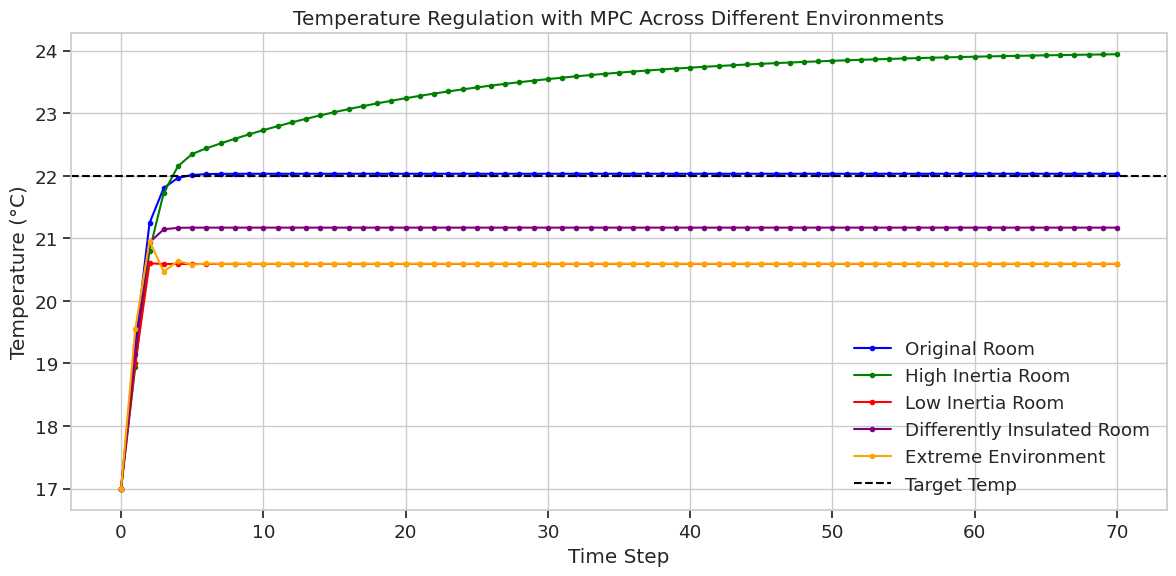

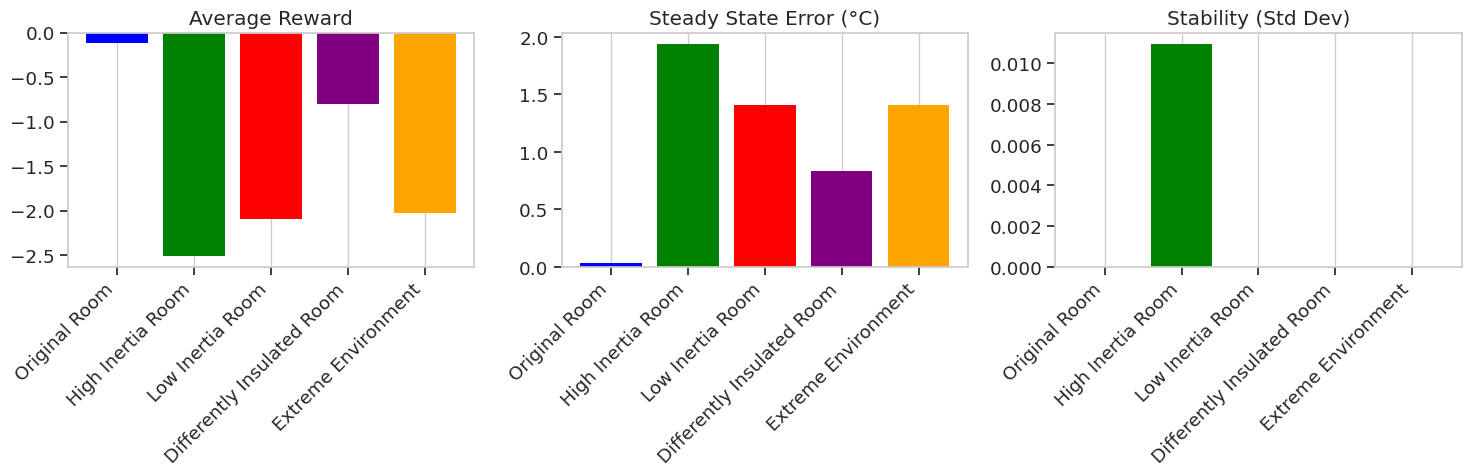

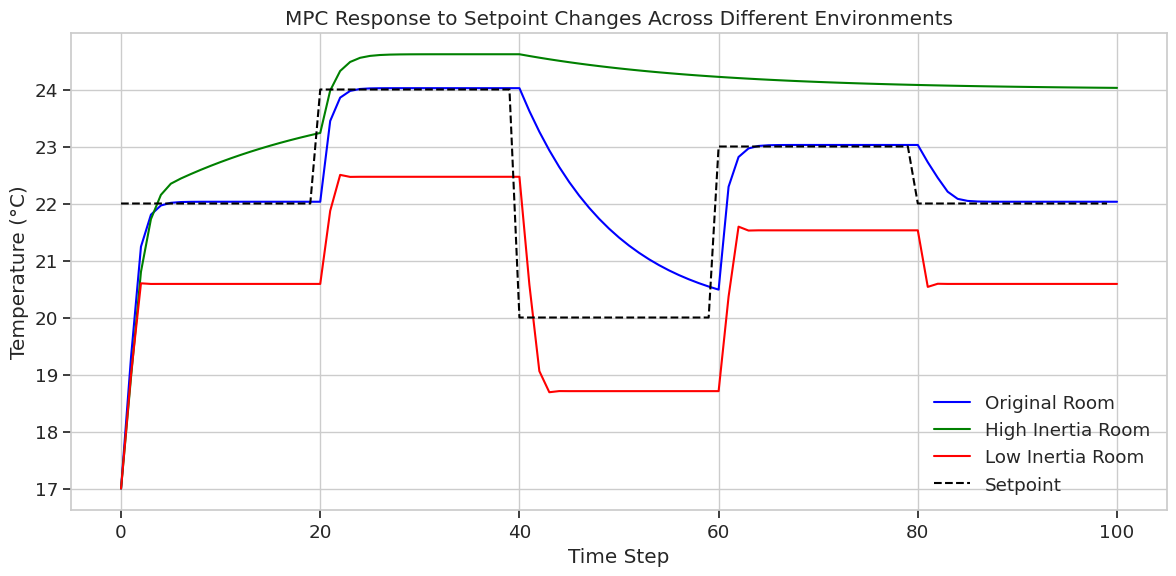

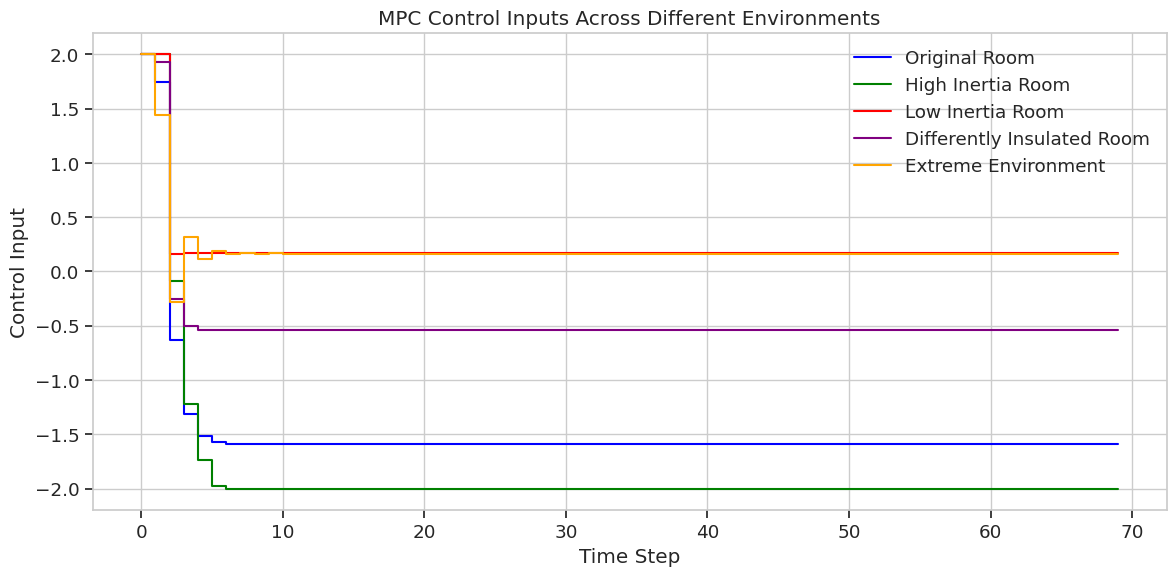

<Figure size 1200x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# ------------------------------
# Environment and model parameters (RC model)
# ------------------------------
a = 0.9     # State transition coefficient
c = 0.5     # Control input coefficient
d = 3       # Constant offset

# Target temperature
T_ref = 22.0

# ------------------------------
# Environment dynamics function
# ------------------------------
def environment_step(T, Q, params):
    """
    Given current temperature T and control input Q, compute the next temperature
    using specified dynamics parameters
    """
    a_val, c_val, d_val = params
    T_next = a_val * T + c_val * Q + d_val
    return T_next

# ------------------------------
# Model Predictive Control (MPC) implementation
# ------------------------------
class MPCController:
    def __init__(self, model_params, prediction_horizon=5, control_horizon=3):
        """
        Initialize MPC controller
        
        Parameters:
        -----------
        model_params : tuple
            Model parameters (a, c, d) for the prediction model
        prediction_horizon : int
            Number of steps to predict into the future
        control_horizon : int
            Number of control actions to optimize
        """
        self.model_params = model_params
        self.prediction_horizon = prediction_horizon
        self.control_horizon = control_horizon
        self.action_bounds = (-2, 2)  # Min and max control actions
        
    def predict_trajectory(self, initial_state, control_sequence):
        """
        Predict future states given an initial state and control sequence
        
        Parameters:
        -----------
        initial_state : float
            Current temperature
        control_sequence : array-like
            Sequence of control actions
            
        Returns:
        --------
        trajectory : list
            Predicted temperature trajectory
        """
        trajectory = [initial_state]
        current_state = initial_state
        
        for u in control_sequence:
            next_state = environment_step(current_state, u, self.model_params)
            trajectory.append(next_state)
            current_state = next_state
            
        return trajectory
    
    def objective_function(self, control_sequence, initial_state, target):
        """
        MPC objective function to minimize
        
        Parameters:
        -----------
        control_sequence : array-like
            Sequence of control actions to optimize
        initial_state : float
            Current temperature
        target : float
            Target temperature
            
        Returns:
        --------
        cost : float
            Cost value to minimize (deviation from target and control effort)
        """
        # Extend control sequence if control horizon < prediction horizon
        if len(control_sequence) < self.prediction_horizon:
            extended_controls = np.append(
                control_sequence, 
                np.repeat(control_sequence[-1], self.prediction_horizon - len(control_sequence))
            )
        else:
            extended_controls = control_sequence[:self.prediction_horizon]
        
        # Predict future trajectory
        trajectory = self.predict_trajectory(initial_state, extended_controls)
        
        # Calculate tracking error cost
        tracking_cost = sum([(x - target) ** 2 for x in trajectory])
        
        # Calculate control effort cost
        control_cost = 0.1 * sum([u ** 2 for u in extended_controls])
        
        # Calculate control smoothness cost (penalize large changes)
        smoothness_cost = 0.05 * sum([(extended_controls[i] - extended_controls[i-1]) ** 2 
                                   for i in range(1, len(extended_controls))])
        
        return tracking_cost + control_cost + smoothness_cost
    
    def optimize_control(self, current_state, target):
        """
        Solve the MPC optimization problem to find optimal control sequence
        
        Parameters:
        -----------
        current_state : float
            Current temperature
        target : float
            Target temperature
            
        Returns:
        --------
        optimal_control : float
            First action from optimal control sequence
        """
        # Initial guess for control sequence (all zeros)
        initial_guess = np.zeros(self.control_horizon)
        
        # Define bounds for all control variables
        bounds = [self.action_bounds for _ in range(self.control_horizon)]
        
        # Solve optimization problem
        result = minimize(
            self.objective_function,
            initial_guess,
            args=(current_state, target),
            method='SLSQP',
            bounds=bounds
        )
        
        # Return first control action from the optimal sequence
        return result.x[0]

# ------------------------------
# Define multiple environment parameter sets for comparison
# ------------------------------
# Original environment
env1 = {
    'name': 'Original Room',
    'params': (0.9, 0.5, 3),  # (a, c, d)
    'color': 'blue'
}

# Environments with different dynamics - varied thermal inertia
env2 = {
    'name': 'High Inertia Room',
    'params': (0.95, 0.4, 2),  # Higher a, lower c, lower d
    'color': 'green'
}

env3 = {
    'name': 'Low Inertia Room',
    'params': (0.8, 0.7, 4),   # Lower a, higher c, higher d
    'color': 'red'
}

env4 = {
    'name': 'Differently Insulated Room',
    'params': (0.85, 0.6, 3.5),  # Different combination of parameters
    'color': 'purple'
}

env5 = {
    'name': 'Extreme Environment',
    'params': (0.75, 0.9, 5),  # Very different dynamics
    'color': 'orange'
}

# List of environments to evaluate
environments = [env1, env2, env3, env4, env5]

# ------------------------------
# Function to evaluate MPC controller on an environment
# ------------------------------
def evaluate_mpc(controller, env_params, initial_temp=17.0, steps=70, target=T_ref):
    """
    Evaluate MPC controller on a given environment
    
    Parameters:
    -----------
    controller : MPCController
        MPC controller to evaluate
    env_params : tuple
        Environment parameters (a, c, d) for the actual environment
    initial_temp : float
        Initial temperature
    steps : int
        Number of simulation steps
    target : float
        Target temperature
        
    Returns:
    --------
    results : dict
        Dictionary with evaluation results
    """
    T_traj = [initial_temp]
    Q_traj = []
    rewards = []
    
    T_current = initial_temp
    for t in range(steps):
        # Get optimal control action from MPC
        Q_opt = controller.optimize_control(T_current, target)
        Q_traj.append(Q_opt)
        
        # Apply action in the actual environment
        T_next = environment_step(T_current, Q_opt, env_params)
        reward = -(T_next - target) ** 2  # Negative squared deviation from target
        rewards.append(reward)
        T_traj.append(T_next)
        T_current = T_next
    
    # Calculate performance metrics
    avg_reward = np.mean(rewards)
    steady_state_err = abs(T_traj[-1] - target)
    stability = np.std(T_traj[-10:])  # Stability in last 10 steps
    
    return {
        'temp_trajectory': T_traj,
        'control_trajectory': Q_traj,
        'rewards': rewards,
        'avg_reward': avg_reward,
        'steady_state_error': steady_state_err,
        'stability': stability
    }

# ------------------------------
# Create MPC controller with original room's model
# ------------------------------
print("Creating MPC controller with original environment model...")
mpc_controller = MPCController(
    model_params=env1['params'],
    prediction_horizon=10,
    control_horizon=5
)

# ------------------------------
# Evaluate the MPC controller on all environments
# ------------------------------
results = {}
for env in environments:
    print(f"Evaluating MPC on {env['name']}...")
    results[env['name']] = evaluate_mpc(mpc_controller, env['params'])
    print(f"  Avg Reward: {results[env['name']]['avg_reward']:.2f}")
    print(f"  Steady State Error: {results[env['name']]['steady_state_error']:.2f}°C")
    print(f"  Stability (Std Dev): {results[env['name']]['stability']:.4f}")

# ------------------------------
# Visualization 1: Temperature trajectories across environments
# ------------------------------
plt.figure(figsize=(12, 6))
for env in environments:
    env_name = env['name']
    temp_traj = results[env_name]['temp_trajectory']
    plt.plot(temp_traj, marker='.', label=env_name, color=env['color'])

plt.axhline(T_ref, color='k', linestyle='--', label='Target Temp')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Regulation with MPC Across Different Environments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mpc_temperature_comparison.png')

# ------------------------------
# Visualization 2: Performance metrics comparison
# ------------------------------
# Create a bar chart to compare performance metrics
metrics = ['avg_reward', 'steady_state_error', 'stability']
metric_names = ['Average Reward', 'Steady State Error (°C)', 'Stability (Std Dev)']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    values = [results[env['name']][metric] for env in environments]
    names = [env['name'] for env in environments]
    colors = [env['color'] for env in environments]
    
    axes[i].bar(names, values, color=colors)
    axes[i].set_title(metric_name)
    axes[i].set_xticklabels(names, rotation=45, ha='right')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.savefig('mpc_performance_metrics.png')

# ------------------------------
# Visualization 3: Temperature response with setpoint changes
# ------------------------------
def simulate_mpc_setpoint_changes(controller, params, setpoint_schedule):
    """
    Simulate MPC controller response to changing temperature setpoints
    """
    steps = len(setpoint_schedule)
    T_traj = [17.0]  # Start with initial temperature
    Q_traj = []
    setpoints = []
    
    T_current = 17.0
    for t in range(steps):
        # Current setpoint
        T_ref_current = setpoint_schedule[t]
        setpoints.append(T_ref_current)
        
        # Get optimal control action from MPC for current setpoint
        Q_opt = controller.optimize_control(T_current, T_ref_current)
        Q_traj.append(Q_opt)
        
        # Apply action in the actual environment
        T_next = environment_step(T_current, Q_opt, params)
        T_traj.append(T_next)
        T_current = T_next
    
    return T_traj, Q_traj, setpoints

# Create setpoint schedule (changing temperature targets)
steps = 100
setpoint_schedule = np.ones(steps) * 22.0  # Default setpoint

# Change setpoints at specific times
setpoint_schedule[20:40] = 24.0  # Increase setpoint to 24°C
setpoint_schedule[40:60] = 20.0  # Decrease setpoint to 20°C
setpoint_schedule[60:80] = 23.0  # Set to 23°C
setpoint_schedule[80:] = 22.0    # Back to default 22°C

# Run simulation with setpoint changes
plt.figure(figsize=(12, 6))

for env in environments[:3]:  # Limit to 3 environments for clarity
    T_traj, Q_traj, setpoints = simulate_mpc_setpoint_changes(mpc_controller, env['params'], setpoint_schedule)
    plt.plot(T_traj, label=f"{env['name']}", color=env['color'])

plt.plot(setpoints, 'k--', label='Setpoint')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("MPC Response to Setpoint Changes Across Different Environments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mpc_setpoint_changes.png')

# ------------------------------
# Visualization 4: Control inputs for different environments
# ------------------------------
plt.figure(figsize=(12, 6))
for env in environments:
    env_name = env['name']
    control_traj = results[env_name]['control_trajectory']
    plt.step(range(len(control_traj)), control_traj, where='post', 
             label=env_name, color=env['color'])

plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.title("MPC Control Inputs Across Different Environments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mpc_control_inputs.png')

# ------------------------------
# Optional: Compare MPC vs perfect model
# ------------------------------
# Create an MPC controller with perfect model knowledge for each environment
perfect_model_results = {}

for env in environments:
    print(f"Evaluating MPC with perfect model on {env['name']}...")
    # Create MPC controller with the actual environment model
    perfect_mpc = MPCController(
        model_params=env['params'],  # Using true environment parameters
        prediction_horizon=10,
        control_horizon=5
    )
    
    # Evaluate with perfect model knowledge
    perfect_model_results[env['name']] = evaluate_mpc(perfect_mpc, env['params'])
    
    # Calculate improvement from using perfect model
    original_sse = results[env['name']]['steady_state_error']
    perfect_sse = perfect_model_results[env['name']]['steady_state_error']
    improvement = ((original_sse - perfect_sse) / original_sse) * 100 if original_sse > 0 else 0
    
    print(f"  Steady State Error with transferred model: {original_sse:.4f}°C")
    print(f"  Steady State Error with perfect model: {perfect_sse:.4f}°C")
    print(f"  Improvement: {improvement:.2f}%")

# Visualize the comparison
plt.figure(figsize=(12, 6))

print("All visualizations completed!")

Training Q-learning agent for 1000 episodes...
Episode 100/1000, Avg Reward: -10.12, Epsilon: 0.6058
Episode 200/1000, Avg Reward: -0.05, Epsilon: 0.3670
Episode 300/1000, Avg Reward: -10.80, Epsilon: 0.2223
Episode 400/1000, Avg Reward: -0.06, Epsilon: 0.1347
Episode 500/1000, Avg Reward: -3.21, Epsilon: 0.0816
Episode 600/1000, Avg Reward: -0.51, Epsilon: 0.0494
Episode 700/1000, Avg Reward: -0.09, Epsilon: 0.0299
Episode 800/1000, Avg Reward: -30.18, Epsilon: 0.0181
Episode 900/1000, Avg Reward: -0.05, Epsilon: 0.0110
Episode 1000/1000, Avg Reward: -4.91, Epsilon: 0.0100

Evaluating original policy on all environments (no fine-tuning)...
Evaluating on Original Room...
  Avg Reward: -2.96
  Steady State Error: 1.55°C
  Stability (Std Dev): 0.1973
Evaluating on High Inertia Room...
  Avg Reward: -3.72
  Steady State Error: 1.99°C
  Stability (Std Dev): 0.0010
Evaluating on Low Inertia Room...
  Avg Reward: -1.71
  Steady State Error: 0.12°C
  Stability (Std Dev): 0.4476
Evaluating on 

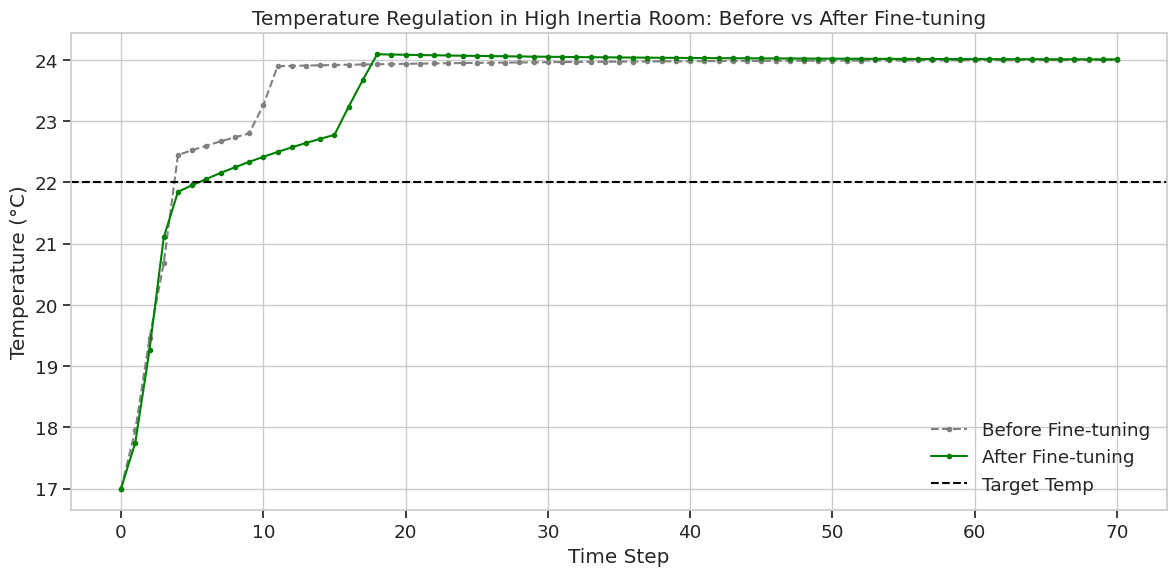

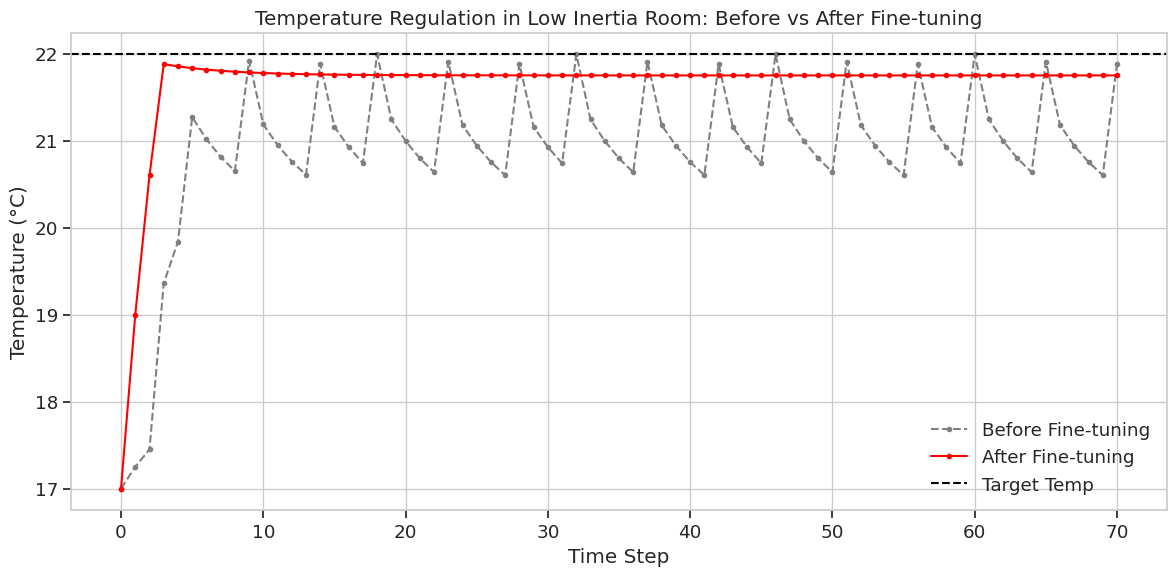

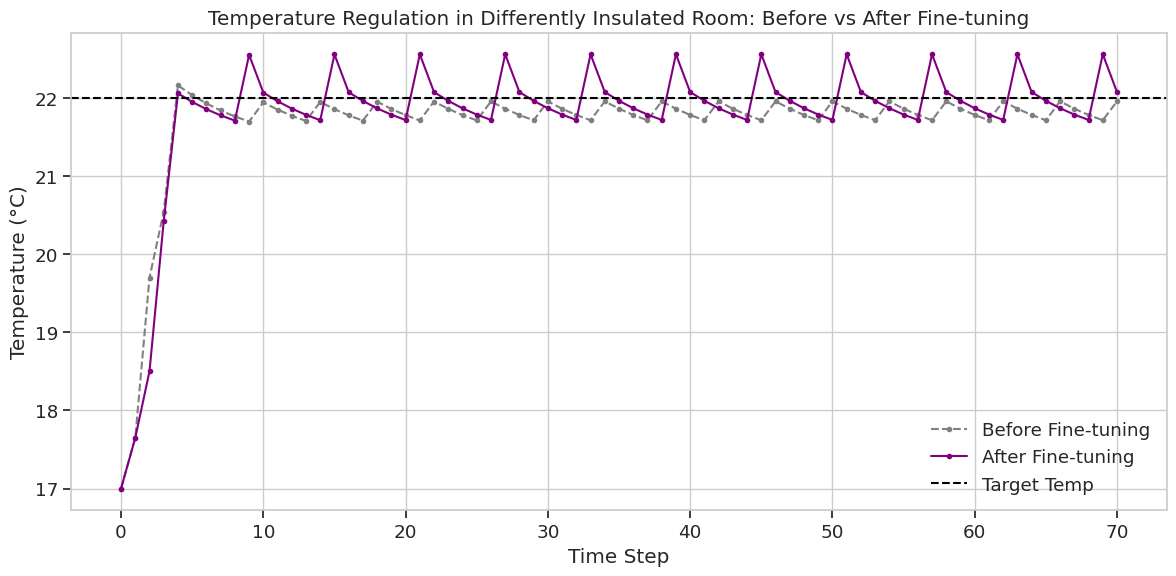

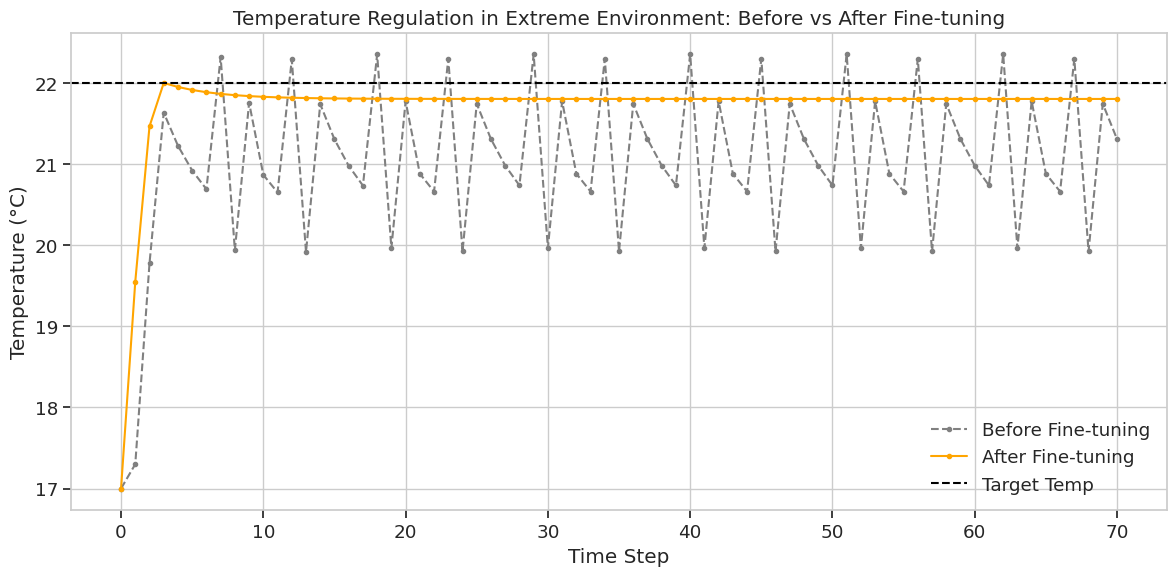

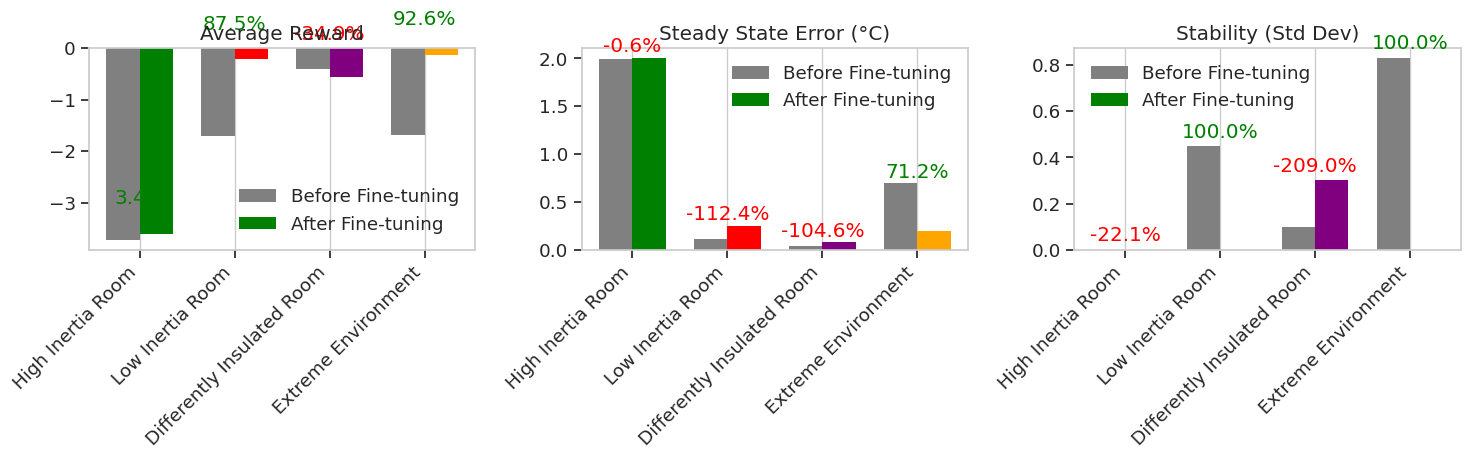

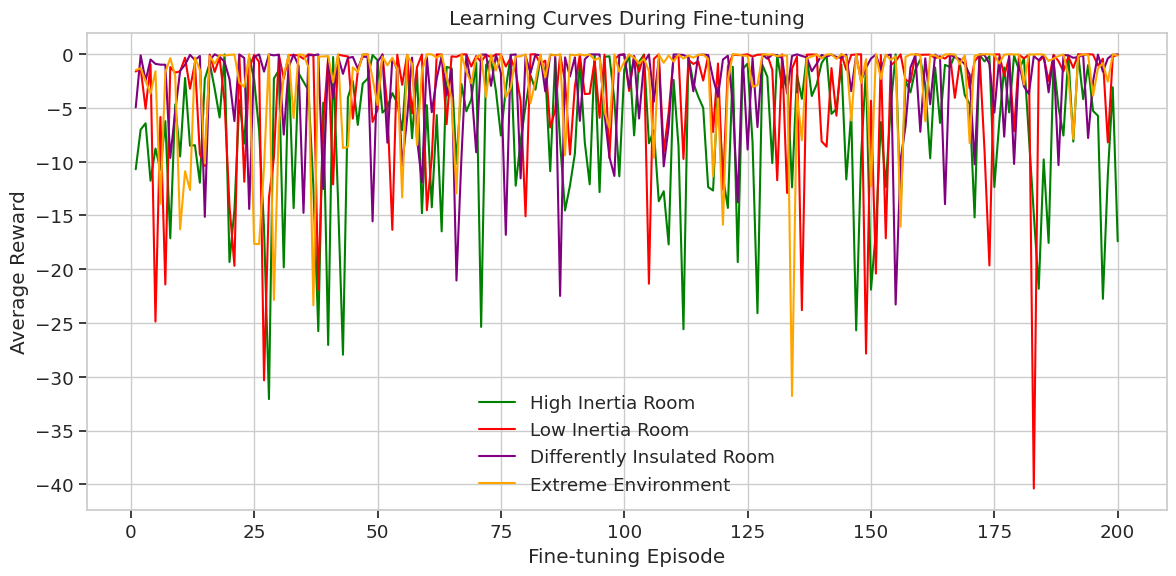

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------
# Environment and model parameters (RC model)
# ------------------------------
a = 0.9     # State transition coefficient
c = 0.5     # Control input coefficient
d = 3       # Constant offset

# Target temperature
T_ref = 22.0

# ------------------------------
# State discretization settings
# ------------------------------
state_min = 10.0   # Lower bound of temperature
state_max = 30.0   # Upper bound of temperature
bin_size = 0.5     # Discretization step size
num_states = int((state_max - state_min) / bin_size) + 1

def discretize_state(T):
    """
    Discretize continuous temperature T into a state index
    """
    idx = int(round((T - state_min) / bin_size))
    idx = max(0, min(idx, num_states - 1))
    return idx

def continuous_state(idx):
    """
    Convert state index back to continuous temperature
    """
    return state_min + idx * bin_size

# ------------------------------
# Discrete action space (heating power levels)
# ------------------------------
# Both heating and cooling are considered here
actions = [0.0, 0.5, 1, 2, -0.5, -1, -2]
num_actions = len(actions)

# ------------------------------
# Environment dynamics function
# ------------------------------
def environment_step(T, Q, params):
    """
    Given current temperature T and control input Q, compute the next temperature
    using specified dynamics parameters
    """
    a_val, c_val, d_val = params
    T_next = a_val * T + c_val * Q + d_val
    return T_next

# ------------------------------
# Reward function
# ------------------------------
def reward_function(T):
    """
    Negative squared deviation from the target temperature
    """
    return - (T - T_ref) ** 2

# ------------------------------
# Q-learning parameters
# ------------------------------
initial_episodes = 1000  # Number of initial training episodes
finetune_episodes = 200  # Number of fine-tuning episodes for new environments
max_steps = 5           # Max steps per episode
alpha_initial = 0.01    # Initial learning rate
alpha_finetune = 0.05   # Learning rate during fine-tuning (higher to adapt faster)
gamma = 0.90            # Discount factor
epsilon_initial = 1.0   # Initial exploration rate
epsilon_min = 0.01      # Minimum epsilon
epsilon_decay = 0.995   # Epsilon decay rate for initial training
epsilon_finetune = 0.2  # Starting epsilon for fine-tuning (higher exploration)

# Original room parameters
orig_params = (a, c, d)

# ------------------------------
# Q-learning training function
# ------------------------------
def train_q_learning(params, episodes, Q_table=None, alpha=0.01, 
                     epsilon_start=1.0, epsilon_min=0.01, 
                     epsilon_decay=0.995, print_interval=100):
    """
    Train Q-learning agent on environment with given parameters.
    Can start with an existing Q-table for fine-tuning.
    
    Returns trained Q-table and rewards history
    """
    # Initialize Q-table if not provided
    if Q_table is None:
        Q_table = np.zeros((num_states, num_actions))
    
    rewards_per_episode = []
    epsilon = epsilon_start
    
    print(f"Training Q-learning agent for {episodes} episodes...")
    
    for episode in range(episodes):
        # Random initial temperature between 15°C and 25°C
        T_current = np.random.uniform(15, 25)
        episode_reward = 0
        
        for step in range(max_steps):
            s = discretize_state(T_current)
            
            # ε-greedy action selection
            if np.random.rand() < epsilon:
                action_index = np.random.randint(num_actions)
            else:
                action_index = np.argmax(Q_table[s])
                
            Q_value = actions[action_index]
            
            # Environment transition
            T_next = environment_step(T_current, Q_value, params)
            r = reward_function(T_next)
            episode_reward += r
            s_next = discretize_state(T_next)
            
            # Q-value update
            best_next = np.max(Q_table[s_next])
            Q_table[s, action_index] += alpha * (r + gamma * best_next - Q_table[s, action_index])
            
            T_current = T_next
        
        rewards_per_episode.append(episode_reward / max_steps)
        
        # Decay epsilon after each episode
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
            
        # Print progress at intervals
        if (episode + 1) % print_interval == 0:
            print(f"Episode {episode + 1}/{episodes}, Avg Reward: {episode_reward/max_steps:.2f}, Epsilon: {epsilon:.4f}")
    
    return Q_table, rewards_per_episode

# ------------------------------
# Define a function to evaluate policy on different environments
# ------------------------------
def evaluate_policy(Q_table, params, initial_temp=17.0, steps=70):
    """
    Evaluate a policy (Q-table) on an environment with specified dynamics parameters
    """
    T_traj = [initial_temp]
    Q_traj = []
    rewards = []
    
    T_current = initial_temp
    for t in range(steps):
        s = discretize_state(T_current)
        best_action_index = np.argmax(Q_table[s])
        Q_opt = actions[best_action_index]
        Q_traj.append(Q_opt)
        
        T_next = environment_step(T_current, Q_opt, params)
        reward = reward_function(T_next)
        rewards.append(reward)
        T_traj.append(T_next)
        T_current = T_next
    
    # Calculate performance metrics
    avg_reward = np.mean(rewards)
    steady_state_err = abs(T_traj[-1] - T_ref)
    stability = np.std(T_traj[-10:])  # Stability in last 10 steps
    
    return {
        'temp_trajectory': T_traj,
        'control_trajectory': Q_traj,
        'rewards': rewards,
        'avg_reward': avg_reward,
        'steady_state_error': steady_state_err,
        'stability': stability
    }

# ------------------------------
# Define multiple environment parameter sets for comparison
# ------------------------------
# Original environment
env1 = {
    'name': 'Original Room',
    'params': (0.9, 0.5, 3),
    'color': 'blue'
}

# Environments with different dynamics - varied thermal inertia
env2 = {
    'name': 'High Inertia Room',
    'params': (0.95, 0.4, 2),  # Higher a, lower c, lower d
    'color': 'green'
}

env3 = {
    'name': 'Low Inertia Room',
    'params': (0.8, 0.7, 4),   # Lower a, higher c, higher d
    'color': 'red'
}

env4 = {
    'name': 'Differently Insulated Room',
    'params': (0.85, 0.6, 3.5),  # Different combination of parameters
    'color': 'purple'
}

env5 = {
    'name': 'Extreme Environment',
    'params': (0.75, 0.9, 5),  # Very different dynamics
    'color': 'orange'
}

# List of environments to evaluate
environments = [env1, env2, env3, env4, env5]

# ------------------------------
# Train Q-learning on original environment
# ------------------------------
original_Q_table, original_rewards = train_q_learning(
    params=env1['params'], 
    episodes=initial_episodes,
    alpha=alpha_initial,
    epsilon_start=epsilon_initial,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay
)

# ------------------------------
# Evaluate original policy on all environments (without fine-tuning)
# ------------------------------
print("\nEvaluating original policy on all environments (no fine-tuning)...")
results_no_finetune = {}

for env in environments:
    print(f"Evaluating on {env['name']}...")
    results_no_finetune[env['name']] = evaluate_policy(original_Q_table, env['params'])
    print(f"  Avg Reward: {results_no_finetune[env['name']]['avg_reward']:.2f}")
    print(f"  Steady State Error: {results_no_finetune[env['name']]['steady_state_error']:.2f}°C")
    print(f"  Stability (Std Dev): {results_no_finetune[env['name']]['stability']:.4f}")

# ------------------------------
# Fine-tune the policy for each new environment
# ------------------------------
print("\nFine-tuning policy for each new environment...")
finetuned_Q_tables = {}
finetune_rewards_history = {}

# First, add the original Q-table to the dictionary
finetuned_Q_tables[env1['name']] = original_Q_table
finetune_rewards_history[env1['name']] = original_rewards

# Fine-tune for each other environment
for env in environments[1:]:  # Skip original environment
    print(f"\nFine-tuning for {env['name']}...")
    
    # Start with the original Q-table and fine-tune it
    env_Q_table, env_rewards = train_q_learning(
        params=env['params'],
        episodes=finetune_episodes,
        Q_table=np.copy(original_Q_table),  # Start with a copy of the original Q-table
        alpha=alpha_finetune,               # Higher learning rate for faster adaptation
        epsilon_start=epsilon_finetune,     # Higher exploration to find new optimal actions
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
        print_interval=50
    )
    
    # Store the fine-tuned Q-table and rewards history
    finetuned_Q_tables[env['name']] = env_Q_table
    finetune_rewards_history[env['name']] = env_rewards

# ------------------------------
# Evaluate fine-tuned policies on their respective environments
# ------------------------------
print("\nEvaluating fine-tuned policies...")
results_finetuned = {}

for env in environments:
    print(f"Evaluating fine-tuned policy on {env['name']}...")
    results_finetuned[env['name']] = evaluate_policy(finetuned_Q_tables[env['name']], env['params'])
    print(f"  Avg Reward: {results_finetuned[env['name']]['avg_reward']:.2f}")
    print(f"  Steady State Error: {results_finetuned[env['name']]['steady_state_error']:.2f}°C")
    print(f"  Stability (Std Dev): {results_finetuned[env['name']]['stability']:.4f}")

# ------------------------------
# Visualization 1: Temperature trajectories comparison (before vs after fine-tuning)
# ------------------------------
for i, env in enumerate(environments[1:], 1):  # Skip original environment
    plt.figure(figsize=(12, 6))
    
    # Plot temperature trajectory without fine-tuning
    temp_traj_no_finetune = results_no_finetune[env['name']]['temp_trajectory']
    plt.plot(temp_traj_no_finetune, 
             marker='.', linestyle='--', 
             label=f"Before Fine-tuning", 
             color='gray')
    
    # Plot temperature trajectory with fine-tuning
    temp_traj_finetuned = results_finetuned[env['name']]['temp_trajectory']
    plt.plot(temp_traj_finetuned, 
             marker='.', 
             label=f"After Fine-tuning", 
             color=env['color'])
    
    plt.axhline(T_ref, color='k', linestyle='--', label='Target Temp')
    plt.xlabel("Time Step")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Temperature Regulation in {env['name']}: Before vs After Fine-tuning")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'temperature_comparison_{env["name"].replace(" ", "_")}.png')

# ------------------------------
# Visualization 2: Performance metrics comparison (before vs after fine-tuning)
# ------------------------------
metrics = ['avg_reward', 'steady_state_error', 'stability']
metric_names = ['Average Reward', 'Steady State Error (°C)', 'Stability (Std Dev)']
improvement_directions = [1, -1, -1]  # 1: higher is better, -1: lower is better

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (metric, metric_name, direction) in enumerate(zip(metrics, metric_names, improvement_directions)):
    # Skip original environment (no fine-tuning needed)
    env_names = [env['name'] for env in environments[1:]]
    before_values = [results_no_finetune[name][metric] for name in env_names]
    after_values = [results_finetuned[name][metric] for name in env_names]
    
    # Calculate improvement percentage
    improvements = []
    for before, after in zip(before_values, after_values):
        if before == 0:
            imp = float('inf') if direction * (after - before) > 0 else 0
        else:
            imp = direction * (after - before) / abs(before) * 100
        improvements.append(imp)
    
    # Set up bar positions
    x = np.arange(len(env_names))
    width = 0.35
    
    # Plot bars
    axes[i].bar(x - width/2, before_values, width, label='Before Fine-tuning', color='gray')
    axes[i].bar(x + width/2, after_values, width, label='After Fine-tuning', color=[env['color'] for env in environments[1:]])
    
    # Add improvement percentages as text
    for j, (x_pos, imp) in enumerate(zip(x, improvements)):
        if metric == 'avg_reward':
            # For reward, higher is better
            color = 'green' if imp > 0 else 'red'
            axes[i].text(x_pos, max(before_values[j], after_values[j]) + 0.5, 
                      f"{imp:.1f}%", ha='center', va='bottom', color=color)
        else:
            # For errors, lower is better
            color = 'green' if imp > 0 else 'red'
            axes[i].text(x_pos, max(before_values[j], after_values[j]) + 0.02, 
                      f"{imp:.1f}%", ha='center', va='bottom', color=color)
    
    axes[i].set_title(metric_name)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(env_names, rotation=45, ha='right')
    axes[i].legend()
    axes[i].grid(axis='y')

plt.tight_layout()
plt.savefig('performance_improvement.png')

# ------------------------------
# Visualization 3: Fine-tuning learning curves
# ------------------------------
plt.figure(figsize=(12, 6))

# Plot fine-tuning learning curves for each environment
for env in environments[1:]:  # Skip original environment
    rewards = finetune_rewards_history[env['name']]
    plt.plot(range(1, len(rewards) + 1), rewards, 
             label=f"{env['name']}", color=env['color'])

plt.xlabel("Fine-tuning Episode")
plt.ylabel("Average Reward")
plt.title("Learning Curves During Fine-tuning")
plt.legend()
plt.grid(True)
plt.tight_layout()